In [93]:
# general purpose modules for handling data
import numpy as np
import pandas as pd

# for loading telo data column containing individual telomere length values
from ast import literal_eval

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mc

# custom module for handling telomere length data
import telomere_methods_astros as telo_ma

# statistics
import scipy.stats as stats
import scikit_posthocs as sp
from statsmodels.stats.anova import AnovaRM

# imputation
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# setting all graphs to have darkgrid style w/ black edges for axes elements
sns.set_style(style="darkgrid",rc={'patch.edgecolor': 'black'})

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hac

import importlib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyzing Mean Telomere Lengths (FISH)
---

## Reading in telomere FISH data

In [324]:
astro_telos_per_cell_df = pd.read_csv('../data/compiled and processed data/exploded_cells_astros_df.csv')

astro_telofish_grouped = astro_telos_per_cell_df.groupby(by=['astro id', 'timepoint', 'flight status']).agg('mean').reset_index()

In [6]:
ctrl_telos_per_cell_df = pd.read_csv('../data/compiled and processed data/exploded_cells_ctrl_df.csv')

ctrl_telos_per_cell_df['flight status'] = 'Controls'
ctrl_telofish_grouped = ctrl_telos_per_cell_df.groupby(by=['control id', 'timepoint', 'flight status']).agg('mean').reset_index()

In [7]:
print(ctrl_telos_per_cell_df.shape)
for status in ['Pre-Flight', 'Mid-Flight', 'Post-Flight']:
    print(astro_telos_per_cell_df[astro_telos_per_cell_df['flight status'] == status].shape)
    
# print(ctrl_telofish_grouped.shape)
# for status in ['Pre-Flight', 'Mid-Flight', 'Post-Flight']:
#     print(astro_telofish_grouped[astro_telofish_grouped['flight status'] == status].shape)

(2010, 6)
(957, 6)
(180, 6)
(1206, 6)


## Mean Telomere Lengths for 11 Astros: Visualizations, Stats (Telo-FISH)

### Bar graph 

In [195]:
concat_astros_ctrl_per_cell = pd.concat([astro_telos_per_cell_df.assign(dataset='set1'),
                                         ctrl_telos_per_cell_df.assign(dataset='set2')], sort=False)

# concat_telofish_grouped = pd.concat([astro_telofish_grouped.assign(dataset='set1'),
#                                      ctrl_telofish_grouped.assign(dataset='set2')], sort=False)

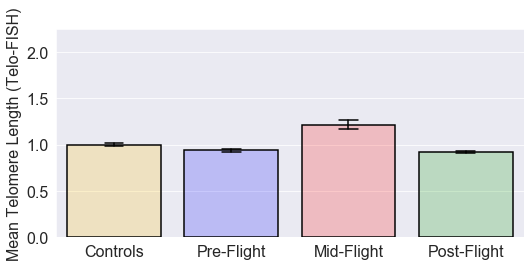

In [241]:
plt.figure(figsize=(8.4, 3.84))
fontsize=16

ax = sns.barplot(x='flight status', y='telo data per cell', data=concat_astros_ctrl_per_cell, 
                 order=['Controls', 'Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                 alpha=None, capsize=0.16, linewidth=1.5, errwidth=1, **{'edgecolor':'black'},
                 ci=95, 
                )

# set alpha to None, enabling assignment of preferred colors to each bar while retaining alpha=1 on bar edges
for i, value in enumerate(['#FFC000', '#0000FF', '#FF0000', '#009900']):
    colors = mc.to_rgba(value)
    empty = (colors[0], colors[1], colors[2], 0.2)
    ax.patches[i].set_facecolor(empty)

plt.setp(ax.lines, color='black', linewidth=1.5)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Mean Telomere Length (Telo-FISH)', fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylim(0, 2.25)

plt.savefig('../MANUSCRIPT 11 ASTROS/figures/mean telomere length (Telo-FISH) 11 unrelated astronuats pre mid post.png', dpi=600)

In [202]:
telo_ma.telos_scipy_anova_post_hoc_tests(df0=concat_astros_ctrl_per_cell, time_col='flight status', 
                                         target='telo data per cell',
                                         sig_test=stats.f_oneway, post_hoc=None, repeated_measures=False)

ONE WAY ANOVA for telomere length: 2.4813332208156835e-41
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
  Controls   Mid-Flight  0.211    0.1519   0.27   True 
  Controls  Post-Flight -0.0814   -0.109 -0.0537  True 
  Controls   Pre-Flight -0.0635  -0.0934 -0.0337  True 
 Mid-Flight Post-Flight -0.2924   -0.353 -0.2317  True 
 Mid-Flight  Pre-Flight -0.2745  -0.3362 -0.2128  True 
Post-Flight  Pre-Flight  0.0179   -0.015  0.0507 False 
-------------------------------------------------------
TukeyHSD pvalues: [0.001, 0.001, 0.001, 0.001, 0.001, 0.50130593191304]


### Lineplot 

### Grouping Telo-FISH data per astronaut/timepoint for lineplot

In [234]:
astro_telofish_grouped = (astro_telos_per_cell_df.groupby(by=['astro id', 'timepoint', 'flight status'])
                                                 .agg('mean').reset_index())

astro_telofish_grouped['timepoint'] = astro_telofish_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

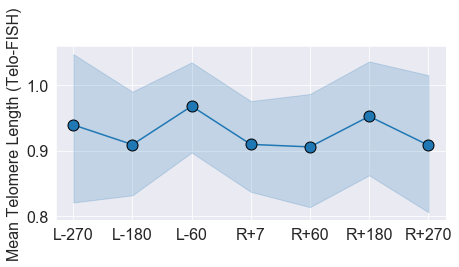

In [304]:
df = astro_telofish_grouped.copy()
df['style'] = 1
df = telo_ma.set_categories_sort(telomere_df=df)

x='timepoint'
y='telo means'
# x_label='Time point'
y_label='Mean Telomere Length (Telo-FISH)'


plt.figure(figsize=(7, 3.2))
fontsize=16
ax = sns.lineplot(x=x, y=y, data=df, style='style', markers=True, legend=False,
                  **{'markersize':11, 'mec':'black', 'mew':1}
#                   hue='astro id',
#                   palette=sns.color_palette("Set2", astro_telofish_grouped['astro id'].nunique())
                 )

plt.xlabel('', fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)

plt.savefig(f'../MANUSCRIPT 11 ASTROS/figures/11 astros lineplot {y} all timepoints.png', dpi=600,
            bbox_inches='tight')

## Longitudinal clustering of Telo-FISH data

### Clustering 11 astros by Telo-FISH data (all timepoints or L-270/R+7/R+270)

In [38]:
astro_telos_per_cell_df = pd.read_csv('../data/compiled and processed data/exploded_cells_astros_df.csv')
astro_telofish_grouped = astro_telos_per_cell_df.groupby(by=['astro id', 
                                                             'timepoint', 
                                                             'flight status']).agg('mean').reset_index()
telofish_cluster_rdy_df = telo_ma.ext_telo_data_longitudinal_clustering(telomere_df=astro_telofish_grouped)

In [40]:
knn_telofish = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telofish_cluster_rdy_df.copy()))
knn_telofish = telo_ma.rename_imputed_df(imputed_df=knn_telofish, original_df=telofish_cluster_rdy_df)
knn_telofish_3 = knn_telofish[['L-270', 'R+7', 'R+270']].copy()

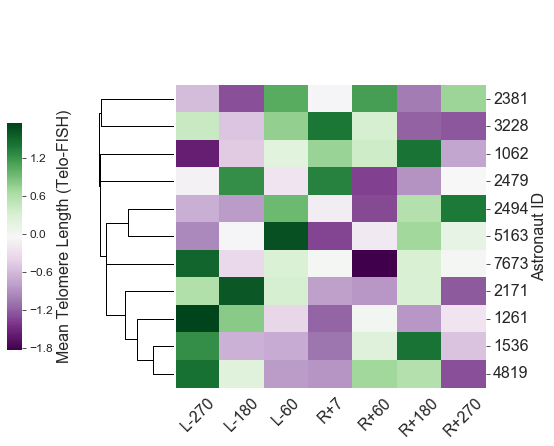

In [306]:
telo_ma.clustermap_plot(knn_telofish, z_score=0, save=True, fontsize=16,
                        path_labels='all timepoints')

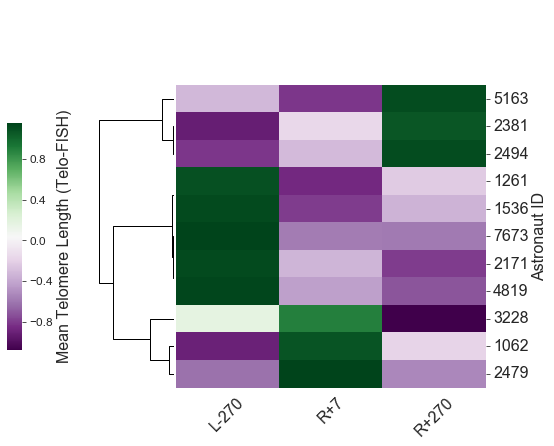

In [327]:
telo_ma.clustermap_plot(knn_telofish_3, z_score=0, save=True, metric='correlation', fontsize=16,
                        path_labels='3 timepoints')

In [41]:
knn_telofish_3['astro id'] = knn_telofish_3.index
knn_melt_fish_3 = knn_telofish_3.melt(id_vars='astro id', 
                                  var_name='timepoint', 
                                  value_name='telo means')
knn_melt_fish_3.rename({'telo means':'Mean Telomere Length (Telo-FISH)'}, axis=1, inplace=True)

In [42]:
knn_melt_fish_3['astro id'] = knn_melt_fish_3['astro id'].astype('str')
knn_melt_fish_3['Clustered groups'] = knn_melt_fish_3['astro id'].apply(lambda row: telo_ma.fish_assign_clustering(row))

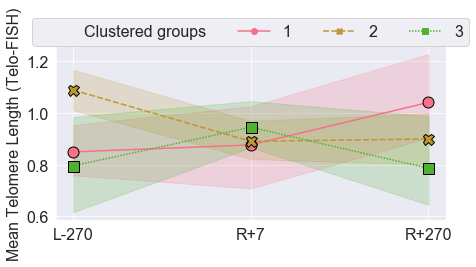

In [43]:
# clustered_graphing = clustered_telos.rename({'Mean Telomere Length (Telo-FISH) cluster groups': 'Clustered groups'}, 
#                                             axis=1).copy()

clustered_graphing = telo_ma.set_categories_sort(telomere_df=knn_melt_fish_3, 
                                                 sort_list=['L-270', 'R+7', 'R+270'])
telo_ma.graph_cluster_groups(clustered_graphing, 
                             target='Mean Telomere Length (Telo-FISH)',
                             y_label_name='Mean Telomere Length (Telo-FISH)',
                             time='timepoint',
                             hue='Clustered groups',
                             colors='husl',
                             n_cols=4,
                             figsize=(7, 3.2),
                             fontsize=16,
                             bbox_to_anchor=(.5, 1.21)
                            )

### Clustering 3 astros by Telo-FISH data (flight status)

In [101]:
knn_telofish = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telofish_cluster_rdy_df.copy()))
knn_telofish = telo_ma.rename_imputed_df(imputed_df=knn_telofish, original_df=telofish_cluster_rdy_df)
knn_telofish['astro id'] = knn_telofish.index
knn_telofish_3_astros = knn_telofish[knn_telofish['astro id'].isin([2171, 5163, 1536])].copy()

In [106]:
grouped_3 = astro_telofish_grouped[astro_telofish_grouped['astro id'].isin([2171, 5163, 1536])].copy()

pivot_3 = grouped_3.pivot_table(index='astro id', columns='flight status', values='telo means')
pivot_3 = pivot_3[['Pre-Flight', 'Mid-Flight', 'Post-Flight']]

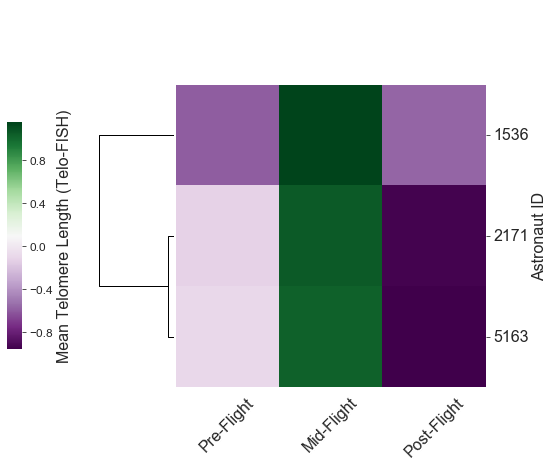

In [113]:
telo_ma.clustermap_plot(pivot_3, z_score=0, save=True, fontsize=16, metric='euclidean',
                        path_labels='3 astros pre mid post')

In [118]:
pivot_3['astro id'] = pivot_3.index
melt_3 = pivot_3.melt(id_vars='astro id', 
                      var_name='flight status', 
                      value_name='telo means')
melt_3.rename({'telo means':'Mean Telomere Length (Telo-FISH)'}, axis=1, inplace=True)

In [119]:
melt_3['astro id'] = melt_3['astro id'].astype('str')
melt_3['Clustered groups'] = melt_3['astro id'].apply(lambda row: 1 if row == '1536' else 2)

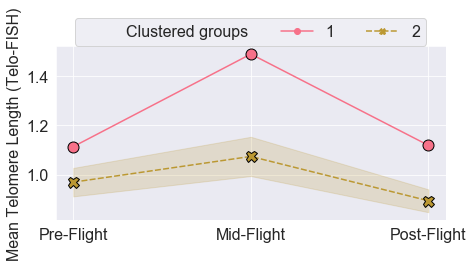

In [123]:
clustered_graphing = telo_ma.set_categories_sort(telomere_df=melt_3,
                                                 time='flight status',
                                                 sort_list=['Pre-Flight', 'Mid-Flight', 'Post-Flight'])
telo_ma.graph_cluster_groups(clustered_graphing, 
                             target='Mean Telomere Length (Telo-FISH)',
                             y_label_name='Mean Telomere Length (Telo-FISH)',
                             time='flight status',
                             hue='Clustered groups',
                             colors='husl',
                             n_cols=4,
                             figsize=(7, 3.2),
                             fontsize=16,
                             bbox_to_anchor=(.5, 1.21),
                             path_labels='3 astros 3 flight status',
                            )

# Analyzing Mean Telomere Lengths (qPCR))
---

## Reading in telomere length (qPCR) data

In [125]:
# astronauts telomere qpcr df
astro_telos_qpcr_df = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[0, 1, 2])
astro_telos_qpcr_df.dropna(axis=0, inplace=True)
astro_telos_qpcr_df['astro id'] = astro_telos_qpcr_df['astro id'].astype('int64')    
astro_telos_qpcr_df['flight status'] = astro_telos_qpcr_df['timepoint'].apply(lambda row: telo_ma.flight_status(row))

In [126]:
astro_telos_qpcr_grouped = (astro_telos_qpcr_df.groupby(by=['astro id', 'timepoint', 'flight status'])
                                               .agg('mean').reset_index())

astro_telos_qpcr_grouped['timepoint'] = astro_telos_qpcr_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

In [52]:
# controls telomere qpcr df
controls_telos_qpcr_df = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[5, 6, 7])
controls_telos_qpcr_df.dropna(axis=0, inplace=True)
controls_telos_qpcr_df['control id'] = controls_telos_qpcr_df['control id'].astype('int64')
controls_telos_qpcr_df.rename({'timepoint.1': 'timepoint', 'Mean Telomere Length (qPCR).1': 'Mean Telomere Length (qPCR)'},
                              axis=1, inplace=True)

controls_telos_qpcr_df['flight status'] = 'Controls'

In [205]:
print(controls_telos_qpcr_df.shape)

for status in ['Pre-Flight', 'Mid-Flight', 'Post-Flight']:
    print(astro_telos_qpcr_df[astro_telos_qpcr_df['flight status'] == status].shape)

(233, 4)
(95, 4)
(18, 4)
(127, 4)


## Mean Telomere Lengths for 11 Astros: Visualizations, Stats (qPCR)

First.. let's see how mean telomere length changes w/ respect to spaceflight when all 11 astronauts are averaged together for pre-, mid-, & post-flight timepoints

In [206]:
concat_astros_ctrl = pd.concat([astro_telos_qpcr_df.assign(dataset='set1'),
                                controls_telos_qpcr_df.assign(dataset='set2')], sort=False)

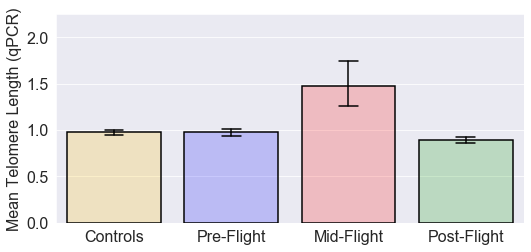

In [240]:
plt.figure(figsize=(8.4, 3.84))
fontsize=16

ax = sns.barplot(x='flight status', y='Mean Telomere Length (qPCR)', data=concat_astros_ctrl, 
                 order=['Controls', 'Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                 alpha=None, capsize=0.16, linewidth=1.5, errwidth=1, **{'edgecolor':'black'},
                 ci=95, 
                )

# set alpha to None, enabling assignment of preferred colors to each bar while
# retaining alpha=1 on bar edges
for i, value in enumerate(['#FFC000', '#0000FF', '#FF0000', '#009900']):
    colors = mc.to_rgba(value)
    empty = (colors[0], colors[1], colors[2], 0.2)
    ax.patches[i].set_facecolor(empty)

plt.setp(ax.lines, color='black', linewidth=1.5)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Mean Telomere Length (qPCR)', fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylim(0, 2.25)

plt.savefig('../MANUSCRIPT 11 ASTROS/figures/mean telomere length (qPCR) 11 unrelated astronuats pre mid post.png', dpi=600)

In [161]:
telo_ma.telos_scipy_anova_post_hoc_tests(df0=concat_astros_ctrl, time_col='flight status', 
                                         target='Mean Telomere Length (qPCR)',
                                         sig_test=stats.f_oneway, post_hoc=None, repeated_measures=False)

ONE WAY ANOVA for telomere length: 1.0874380074447757e-19
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
  Controls   Mid-Flight   0.5     0.3618  0.6382  True 
  Controls  Post-Flight  -0.09   -0.1523 -0.0277  True 
  Controls   Pre-Flight -0.0024  -0.0711  0.0664 False 
 Mid-Flight Post-Flight -0.5899  -0.7322 -0.4476  True 
 Mid-Flight  Pre-Flight -0.5023  -0.6476 -0.3571  True 
Post-Flight  Pre-Flight  0.0876   0.011   0.1642  True 
-------------------------------------------------------
TukeyHSD pvalues: [0.001, 0.0012629068841544244, 0.9, 0.001, 0.001, 0.017656696315270115]

bonferroni pvalues


,Pre-Flight,Mid-Flight,Post-Flight,Controls
Pre-Flight,-1.000000,0.007862,0.002417,1.000000
Mid-Flight,0.007862,-1.000000,0.001816,0.008103
Post-Flight,0.002417,0.001816,-1.000000,0.000173
Controls,1.000000,0.008103,0.000173,-1.000000


### Lineplot

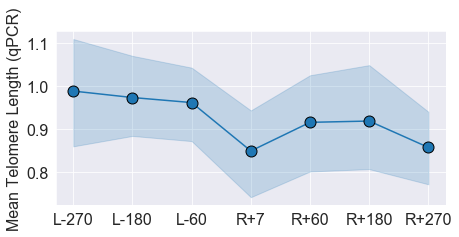

In [305]:
df = astro_telos_qpcr_grouped.copy()
df['style'] = 1
df = telo_ma.set_categories_sort(telomere_df=df)

x='timepoint'
y='Mean Telomere Length (qPCR)'
x_label='Time point'
y_label='Mean Telomere Length (qPCR)'


plt.figure(figsize=(7, 3.2))
fontsize=16
ax = sns.lineplot(x=x, y=y, data=df, style='style', markers=True, legend=False,
                  **{'markersize':11, 'mec':'black', 'mew':1}
#                   hue='astro id',
#                   palette=sns.color_palette("Set2", astro_telofish_grouped['astro id'].nunique())
                 )

plt.xlabel('', fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)

plt.savefig(f'../MANUSCRIPT 11 ASTROS/figures/11 astros lineplot {y} all timepoints.png', dpi=600,
           bbox_inches='tight')

## Longitudinal clustering of telomere (qPCR) data

### Clustering 11 astros by telomere qPCR data (all timepoints or L-270/R+7/R+270)

In [173]:
# astronauts telomere qpcr df
astro_telos_qpcr_df = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[0, 1, 2])
astro_telos_qpcr_df.dropna(axis=0, inplace=True)
astro_telos_qpcr_df['astro id'] = astro_telos_qpcr_df['astro id'].astype('int64')    
astro_telos_qpcr_df['flight status'] = astro_telos_qpcr_df['timepoint'].apply(lambda row: telo_ma.flight_status(row))

astro_telos_qpcr_grouped = (astro_telos_qpcr_df.groupby(by=['astro id', 'timepoint', 'flight status']).agg('mean').reset_index())
astro_telos_qpcr_grouped['timepoint'] = astro_telos_qpcr_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

In [174]:
telo_qpcr_cluster_rdy_df = telo_ma.ext_telo_data_longitudinal_clustering(telomere_df=astro_telos_qpcr_grouped,
                                                                         telomere_col_name='Mean Telomere Length (qPCR)')

In [175]:
knn_telo_qpcr = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telo_qpcr_cluster_rdy_df.copy()))
knn_telo_qpcr = telo_ma.rename_imputed_df(imputed_df=knn_telo_qpcr, original_df=telo_qpcr_cluster_rdy_df)

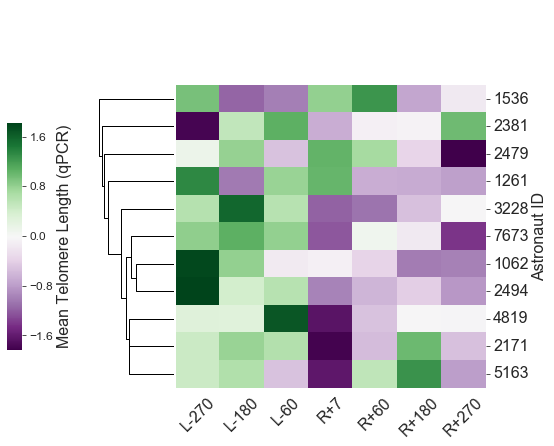

In [193]:
telo_ma.clustermap_plot(knn_telo_qpcr, y_label='Mean Telomere Length (qPCR)', 
                        metric='euclidean', save=True, z_score=0, fontsize=16,
                        path_labels='all timepoints')

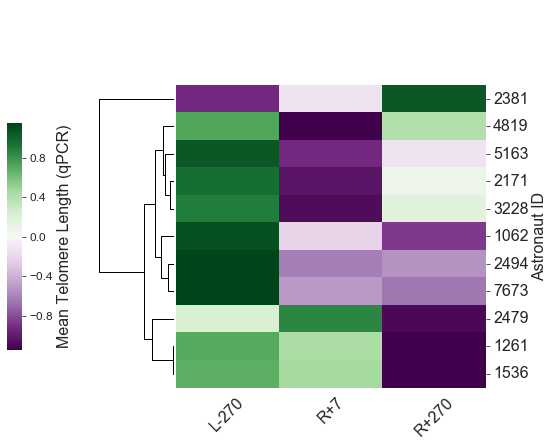

In [192]:
knn_telo_qpcr_3 = knn_telo_qpcr[['L-270', 'R+7', 'R+270']].copy()
telo_ma.clustermap_plot(knn_telo_qpcr_3, y_label='Mean Telomere Length (qPCR)', 
                        metric='euclidean', save=True, z_score=0, fontsize=16,
                        path_labels='3 timepoints')

In [308]:
knn_telo_qpcr_3['astro id'] = knn_telo_qpcr_3.index
knn_melt_3 = knn_telo_qpcr_3.melt(id_vars='astro id', 
                                  var_name='timepoint', 
                                  value_name='Mean Telomere Length (qPCR)')

In [309]:
knn_melt_3['Clustered groups'] = knn_melt_3['astro id'].astype('str').apply(lambda row: telo_ma.qpcr_assign_cluster(row))

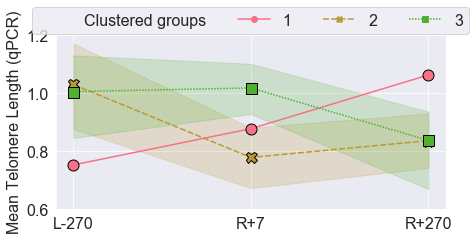

In [323]:
clustered_graphing = telo_ma.set_categories_sort(telomere_df=knn_melt_3, sort_list=['L-270', 'R+7', 'R+270'])
telo_ma.graph_cluster_groups(clustered_graphing, 
                             target='Mean Telomere Length (qPCR)',
                             y_label_name='Mean Telomere Length (qPCR)',
                             time='timepoint',
                             hue='Clustered groups',
                             colors='husl',
                             n_cols=4,
                             figsize=(7, 3.2),
                             fontsize=16,
                             bbox_to_anchor=(.5, 1.21),
                             y_lim=(0.6, 1.2)
                            )

### Clustering 3 astros by telomere qPCR data (flight status)

In [101]:
# knn_telofish = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telofish_cluster_rdy_df.copy()))
# knn_telofish = telo_ma.rename_imputed_df(imputed_df=knn_telofish, original_df=telofish_cluster_rdy_df)
# knn_telofish['astro id'] = knn_telofish.index
# knn_telofish_3_astros = knn_telofish[knn_telofish['astro id'].isin([2171, 5163, 1536])].copy()

In [136]:
grouped_3 = astro_telos_qpcr_grouped[astro_telos_qpcr_grouped['astro id'].isin([2171, 5163, 1536])].copy()

pivot_3 = grouped_3.pivot_table(index='astro id', columns='flight status', values='Mean Telomere Length (qPCR)')
pivot_3 = pivot_3[['Pre-Flight', 'Mid-Flight', 'Post-Flight']]

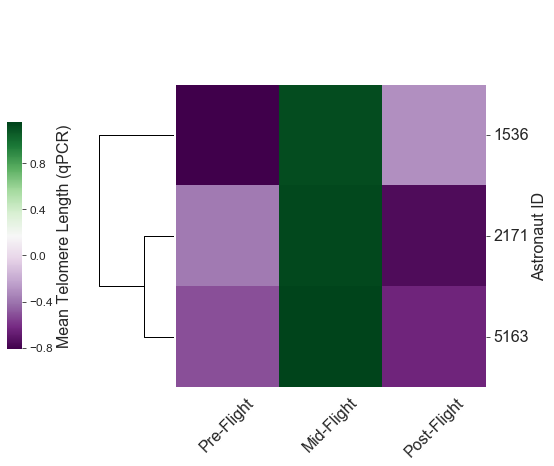

In [138]:
telo_ma.clustermap_plot(pivot_3, z_score=0, save=True, fontsize=16, metric='euclidean',
                        y_label='Mean Telomere Length (qPCR)',
                        path_labels='3 astros qPCR pre mid post')

In [132]:
pivot_3['astro id'] = pivot_3.index
melt_3 = pivot_3.melt(id_vars='astro id', 
                      var_name='flight status', 
                      value_name='Mean Telomere Length (qPCR)')

In [133]:
melt_3['astro id'] = melt_3['astro id'].astype('str')
melt_3['Clustered groups'] = melt_3['astro id'].apply(lambda row: 1 if row == '1536' else 2)

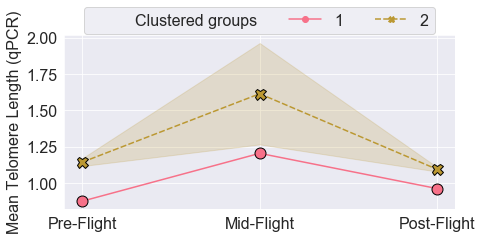

In [135]:
clustered_graphing = telo_ma.set_categories_sort(telomere_df=melt_3,
                                                 time='flight status',
                                                 sort_list=['Pre-Flight', 'Mid-Flight', 'Post-Flight'])
telo_ma.graph_cluster_groups(clustered_graphing, 
                             target='Mean Telomere Length (qPCR)',
                             y_label_name='Mean Telomere Length (qPCR)',
                             time='flight status',
                             hue='Clustered groups',
                             colors='husl',
                             n_cols=4,
                             figsize=(7, 3.2),
                             fontsize=16,
                             bbox_to_anchor=(.5, 1.21),
                             path_labels='3 astros 3 flight status',
                            )

## Mean Telomere Lengths for 3 Astros: Visualizations, Stats

In [27]:
only_inflight_astros_df = (astro_telos_per_cell_df[astro_telos_per_cell_df
                                                   ['astro id'].isin(['2171', '1536', '5163'])].copy())

In [28]:
only_inflight_concat_astros_ctrl_per_cell = pd.concat([only_inflight_astros_df.assign(dataset='set1'),
    ctrl_telos_per_cell_df.assign(dataset='set2')], sort=False)

Text(0, 0.5, 'Mean Telomere Length (per cell)')

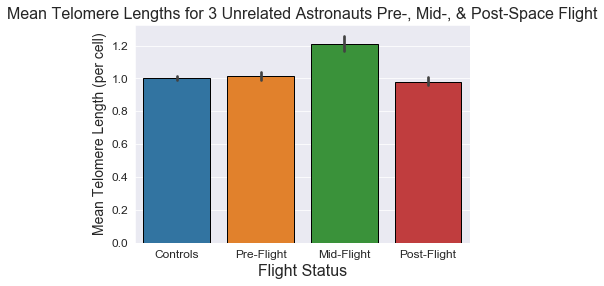

In [94]:
ax = sns.barplot(x='flight status', y='telo data per cell', data=only_inflight_concat_astros_ctrl_per_cell, 
            order=['Controls', 'Pre-Flight', 'Mid-Flight', 'Post-Flight'])

ax.set_title('Mean Telomere Lengths for 3 Unrelated Astronauts Pre-, Mid-, & Post-Space Flight', fontsize=16)
ax.set_xlabel('Flight Status', fontsize=16)
ax.set_ylabel('Mean Telomere Length (per cell)', fontsize=14)

In [29]:
only_inflight_astros_df.rename(columns={'flight status':'flight_status',
                                        'telo data per cell':'telo_data_per_cell',
                                        'astro id':'astro_id'}, inplace=True)

In [30]:
data_AnovaRM = AnovaRM(only_inflight_astros_df,
                       'telo_data_per_cell',
                       'astro_id',
                       within=['flight_status'],
                       aggregate_func=np.mean).fit()
print(data_AnovaRM)

                  Anova
              Num DF Den DF F Value Pr > F
------------------------------------------
flight_status 2.0000 4.0000  7.7171 0.0424



In [32]:
telo_ma.scipy_anova_post_hoc_tests(df=only_inflight_astros_df, flight_status_col='flight_status', 
                                   target='telo_data_per_cell')

ONE WAY ANOVA for telomere length: 3.6259349154492387e-22


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000e+00,2.256336e-11,2.049158e-01
Mid-Flight,2.256336e-11,-1.000000e+00,1.308997e-15
Post-Flight,2.049158e-01,1.308997e-15,-1.000000e+00


In [98]:
for astro in only_inflight_astros_df['astro_id'].unique():
    df = only_inflight_astros_df[only_inflight_astros_df['astro_id'] == astro]

    print(f'dso{astro}')
    telo_ma.scipy_anova_post_hoc_tests(df=df, flight_status_col='flight_status', target='telo_data_per_cell')
    print('\n')

dso5163
ONE WAY ANOVA for telomere length: 1.1747882780532057e-05


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000,4.096814e-03,2.401263e-02
Mid-Flight,0.004097,-1.000000e+00,4.121802e-07
Post-Flight,0.024013,4.121802e-07,-1.000000e+00




dso1536
ONE WAY ANOVA for telomere length: 8.310501727442927e-32


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000e+00,1.020269e-17,8.820374e-01
Mid-Flight,1.020269e-17,-1.000000e+00,5.808740e-18
Post-Flight,8.820374e-01,5.808740e-18,-1.000000e+00




dso2171
ONE WAY ANOVA for telomere length: 6.063450212542442e-07


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000,1.436052e-02,2.447365e-03
Mid-Flight,0.014361,-1.000000e+00,5.707448e-07
Post-Flight,0.002447,5.707448e-07,-1.000000e+00


In [12]:
for astro in only_inflight_astros_df['astro_id'].unique():
    df = only_inflight_astros_df[only_inflight_astros_df['astro_id'] == astro]

    print(f'dso{astro}')
    telo_ma.scipy_anova_post_hoc_tests(df=df, flight_status_col='flight_status', target='telo_data_per_cell')
    print('\n')

dso5163
ONE WAY ANOVA for telomere length: 1.1747882780532057e-05


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000,0.012290,0.072038
Mid-Flight,0.012290,-1.000000,0.000001
Post-Flight,0.072038,0.000001,-1.000000




dso1536
ONE WAY ANOVA for telomere length: 8.310501727442927e-32


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000e+00,3.060806e-17,1.000000e+00
Mid-Flight,3.060806e-17,-1.000000e+00,1.742622e-17
Post-Flight,1.000000e+00,1.742622e-17,-1.000000e+00




dso2171
ONE WAY ANOVA for telomere length: 6.063450212542442e-07


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000,0.043082,0.007342
Mid-Flight,0.043082,-1.000000,0.000002
Post-Flight,0.007342,0.000002,-1.000000


These 3 astronauts are our only individuals w/ inflight data, so the mid-flight mean telomere length has remained the same. The pre-/post-flight data has the same relationship compared to the data for all 11 astronauts: post-flight mean telomere length is *slightly* shorter.

Now.. our inflight astronauts had blood samples collected at different flight days. Let's first parse out the mean telomere length data per astronaut.

## Examining Mean Telomere Length @ Mid-Flight 1 vs. 2

Text(0.5, 1.0, 'Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight')

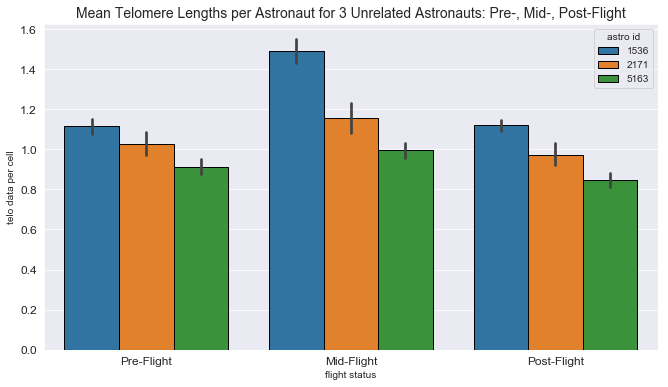

In [22]:
fig = plt.figure(figsize=(11,6))
ax = sns.barplot(x='flight status', y='telo data per cell', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], 
                   hue='astro id', data=only_inflight_astros_df, dodge=True)

ax.set_title('Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight', fontsize=14)

Even when considered separately, for each astronaut the average of mean telomere length for their samples taken midflight was always longer than the average of samples pre-flight. As well, the average of mean telomere length for samples post-flight were slightly shorter. Interestingly, dso2171 looks to have similar mean telomere length for both blood draws.

Now we must consider if mean telomere length increases as a function of *duration in spaceflight*. We can do so b.c astros 1536&5163 samples were collected at FD90 & 140, while astro 2171 samples were collected at FD45 & 260. Let's first parse out the two mid-flight timepoints, then examine mid 1 & mid 2 for each astronaut

In [23]:
only_inflight_astros_df['flight status mid split'] = only_inflight_astros_df.loc[:, 'timepoint'].apply(lambda row: telo_ma.mid_split(row))
ctrl_telos_per_cell_df['flight status mid split'] = 'Controls'

In [24]:
only_inflight_concat_df = pd.concat([only_inflight_astros_df.assign(dataset='set1'),
                                     ctrl_telos_per_cell_df.assign(dataset='set2')], sort=False)

Text(0.5, 1.0, 'Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

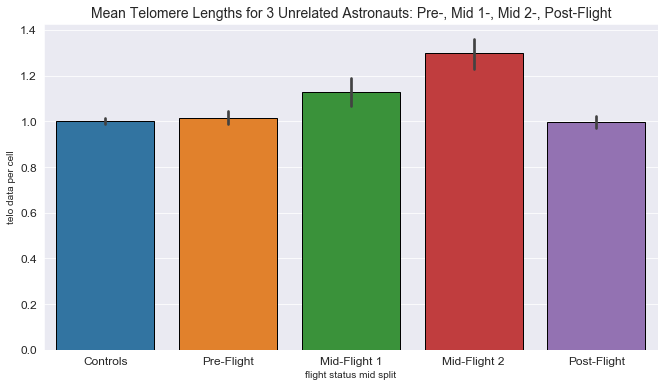

In [25]:
fig = plt.figure(figsize=(11,6))
ax = sns.barplot(x='flight status mid split', y='telo data per cell', 
                   order=['Controls', 'Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
                 data=only_inflight_concat_df)

ax.set_title('Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight', fontsize=14)

The average of mean telomere lengths for mid-flight 2 is certainly higher than for mid-flight 1. There may be some relationship between telomere lengthening and spaceflight duration. However, telomere length may have a normal biological upper bound, though numerically undefined, thus it's unlikely that telomere length would increase indefinitely via spaceflight. Let's see how the data looks per astronaut.

Text(0.5, 1.0, 'Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

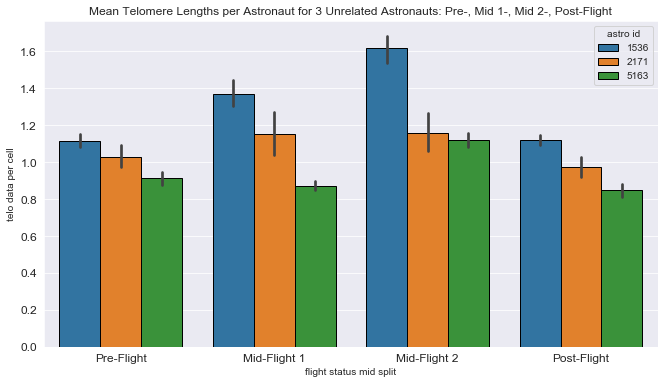

In [26]:
fig = plt.figure(figsize=(11,6))
ax = sns.barplot(x='flight status mid split', y='telo data per cell', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
                   hue='astro id', data=only_inflight_astros_df, dodge=True)

ax.set_title('Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

Astros 1536 & 5163 blood draws occured at FD90 & FD140, and both experienced an increase in mean telomere length at mid-flight 1 relative to pre-flight, and experienced an additional increase over mid-flight 1 at mid-flight 2.

Astro 2171 had blood draws at FD45 & FD260, and while mid-flight 1 had increased mean telomere length relative to pre-flight, mid-flight 2 was not. Rather, mid-flight 2 was numerically close to mid-flight 1. Altogether, mean telomere length does not appear to increase indefinitely with spaceflight. Our limited # of datapoints suggest that while mean telomere length increases mid-flight, it does not increase indefinitely.

Let's look at individual telomere lengths.

In [68]:
df123 = astro_telofish_grouped.merge(astro_telos_qpcr_grouped, on=['astro id', 'timepoint'])

In [69]:
df123.corr()

,astro id,astro number,telo means,telo data per cell,Mean Telomere Length (qPCR)
astro id,1.000000,-0.300890,-0.326533,-0.326533,0.112751
astro number,-0.300890,1.000000,-0.314122,-0.314122,-0.402753
telo means,-0.326533,-0.314122,1.000000,1.000000,0.273067
telo data per cell,-0.326533,-0.314122,1.000000,1.000000,0.273067
Mean Telomere Length (qPCR),0.112751,-0.402753,0.273067,0.273067,1.000000


# Analyzing Individual Telomere Length Distributions (FISH)

## Reading data

In [139]:
exploded_telos_astro_df = pd.read_csv('../data/compiled and processed data/exploded_telos_astros_df.csv')
exploded_telos_astro_df['astro id'] = exploded_telos_astro_df['astro id'].astype('str')

exploded_telos_astro_df.head(4)

,astro number,astro id,timepoint,flight status,telo means,telo data exploded
0,1,5163,L-270,Pre-Flight,87.672120,132.793184
1,1,5163,L-180,Pre-Flight,101.077756,72.034748
2,1,5163,L-60,Pre-Flight,128.599235,89.558971
3,1,5163,FD90,Mid-Flight,101.183129,77.530905


## Graphing individual telos per cluster (identified w/ Telo-FISH data, above)

In [140]:
telofish_cluster_rdy_df

,L-270,L-180,L-60,R+7,R+60,R+180,R+270
astro id,,,,,,,
1062,0.616396,0.762968,0.854591,0.922433,0.876242,1.013439,0.726596
1261,1.159119,1.080128,0.981414,0.915232,1.014480,0.942625,0.994209
1536,1.226707,1.058564,1.055727,1.023692,1.138463,1.242517,1.071685
2171,NaN,1.082756,0.971538,NaN,NaN,0.969010,0.836087
2381,0.836300,0.752749,1.030080,0.895820,1.041592,0.782033,0.991447
2479,0.985568,1.042869,0.980222,1.046551,0.932544,0.952847,0.988553
2494,0.954294,0.936525,1.171729,1.026551,0.871249,1.122747,1.228721
3228,0.785687,0.707259,0.813880,0.867297,0.777300,0.649883,0.645227
4819,1.000304,0.883996,0.780955,0.777611,0.928083,0.917776,0.736069


In [141]:
# pulling out L-270 / R+270
parsed_L270_R270 = exploded_telos_astro_df[exploded_telos_astro_df['timepoint'].isin(['L-270', 'R+270'])].copy()

In [ ]:
# swapping 2171 L-180 & 5163 R+180 data w/ L-270 & R+270 to facilitate analysis of most distal pre/post timepoints
df = exploded_telos_astro_df.copy()

parsed_2171_L180_to_270 = df[(df['astro id'] == '2171') & (df['timepoint'] == 'L-180')].copy()
parsed_2171_L180_to_270['timepoint'] = 'L-270'

parsed_5163_R180_to_270 = df[(df['astro id'] == '2171') &  (df['timepoint'] == 'R+180')].copy()
parsed_5163_R180_to_270['timepoint'] = 'R+270'

parsed_df = pd.concat([parsed_L270_R270, 
                       parsed_2171_L180_to_270,
                       parsed_5163_R180_to_270], axis=0)

parsed_df['Clustered group'] = parsed_df['astro id'].apply(lambda row: telo_ma.fish_assign_clustering(row))

In [19]:
telo_ma.make_histograms_colored_by_quartile_for_astronauts(exploded_telos_less_mid_astros_df, astro_ids2)

,astro number,astro id,timepoint,flight status,telo means,telo data exploded
2171,7,2171,L-180,Pre-Flight,122.145968,103.240741


In [112]:
# taking only midflight astros
exploded_telos_only_mid_astros_df = exploded_telos_astro_df[exploded_telos_astro_df['astro id'].isin(['5163', 
                                                                                                      '1536', 
                                                                                                      '2171'])].copy()
exploded_telos_only_mid_astros_df.shape

(132480, 6)

In [6]:
exploded_telos_only_mid_astros_df['flight status mid split'] = (exploded_telos_only_mid_astros_df['timepoint']
                                                                .apply(lambda row: telo_ma.mid_split(row)))

We've seen that mean telomere length increases during spaceflight. Now let us define short&long telomeres and visualize individual telomere length distributions per astronaut for timepoints most distal to spaceflight. 

To define short & long telomeres, we'll first find the earliest pre-flight samples for each astronaut. Then, in the individual telomere length distribution for that sample, we'll find the quartile boundary values for the bottom 25% of telos (short telos), middle 50%, and top 25% (long telos). The short, medium, and long telomeres will be colored yellow, blue, and pink respectively.

Once the quartile boundary values are established by the earliest pre-flight timepoint, the quartile boundary values will be used to color both midflight samples and the latest post-flight sample. In doing so, we can visualize and quantify the shifts of short/mid/long telomeres for each sample relative to the earliest timepoint. Now we have a means to discuss these classes of telomeres.

In [7]:
exploded_telos_only_mid_astros_df['encoded astro id'] = (exploded_telos_only_mid_astros_df['astro id']
                                                         .apply(lambda row: telo_ma.id_encode_letters(row)))

## Telo Distributions: 3 Inflight Astros

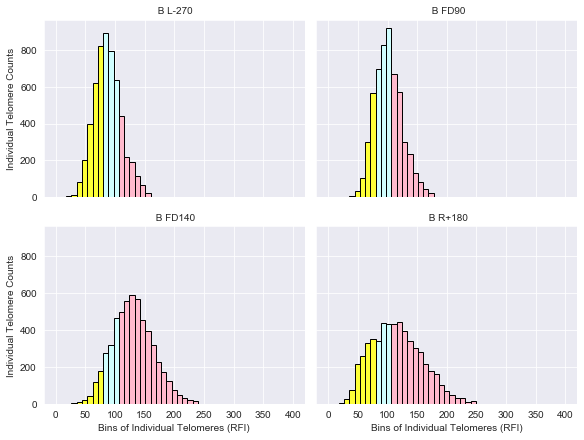

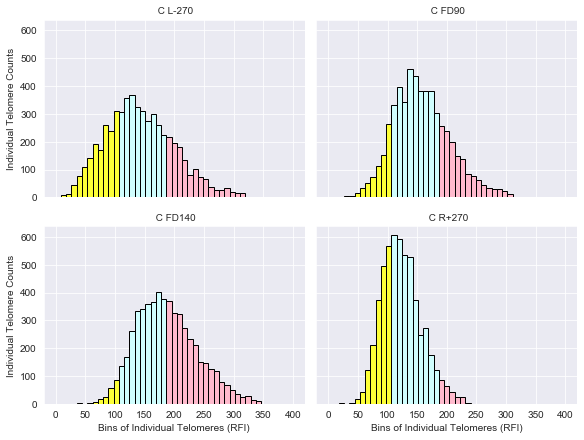

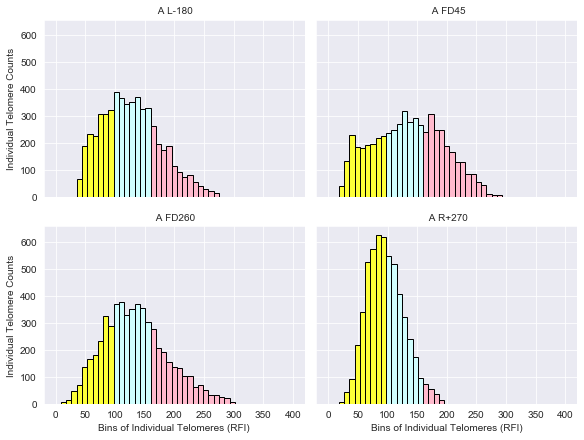

In [11]:
exploded_telos_only_mid_astros_df['encoded astro id'] = (exploded_telos_only_mid_astros_df['encoded astro id']
                                                         .astype('str'))
astro_ids = list(exploded_telos_only_mid_astros_df['encoded astro id'].unique())
telo_ma.make_histograms_colored_by_quartile_for_encoded_astronauts(exploded_telos_only_mid_astros_df, astro_ids,
                                                                   n_bins=45)

## Statistics

In [104]:
df = exploded_telos_only_mid_astros_df.copy()
stats_df = pd.DataFrame()

astro_ids = ['2171', '1536', '5163']
timepoints = [['L-180', 'FD45', 'FD260', 'R+270'],
              ['L-270', 'FD90', 'FD140', 'R+270'],
              ['L-270', 'FD90', 'FD140', 'R+180']]

for astro_id, timepts in zip(astro_ids, timepoints):
    parse_df = df[(df['astro id'] == astro_id) & df['timepoint'].isin(timepts)].copy()
    print(astro_id)
    telo_ma.eval_make_test_comparisons(df=parse_df, timepoints=timepoints, target='telo data exploded',
                                       test=stats.mannwhitneyu, test_name='MannWhitney-U')
    print('\n')
#     stats_df = pd.concat([stats_df, parse_df], axis=0)

2171
MannWhitney-U | L-180 vs FD45 2.8618244221912324e-13
MannWhitney-U | L-180 vs FD260 8.093940362264684e-10
MannWhitney-U | L-180 vs R+270 2.8078400480379007e-262
MannWhitney-U | FD45 vs FD260 0.043677723748544915
MannWhitney-U | FD45 vs R+270 3.3514181298542373e-292
MannWhitney-U | FD260 vs R+270 0.0


1536
MannWhitney-U | L-270 vs FD90 4.913060938825804e-51
MannWhitney-U | L-270 vs FD140 0.0
MannWhitney-U | L-270 vs R+270 5.4073451687223204e-74
MannWhitney-U | FD90 vs FD140 3.0580427326492194e-202
MannWhitney-U | FD90 vs R+270 0.0
MannWhitney-U | FD140 vs R+270 0.0


5163
MannWhitney-U | L-270 vs FD90 1.9597674709370873e-191
MannWhitney-U | L-270 vs FD140 0.0
MannWhitney-U | L-270 vs R+180 1.18508256647335e-294
MannWhitney-U | FD90 vs FD140 0.0
MannWhitney-U | FD90 vs R+180 3.4788046055308945e-71
MannWhitney-U | FD140 vs R+180 1.6124293618968286e-91




Intriguingly, we see a *decrease* in short telos and an *increase* in long telos inflight. Furthermore, 2/3 astronauts experienced a remarkable increase in short telomeres post-flight. Now, let us quantify and visualize the #s of short/medium/long telomeres for the complete timecourse for these 3 unrelated astronauts.

## Feature engineering short/long telos: 3 Inflight Astros

In [19]:
melted_quartiles_astro_df = pd.read_csv('../data/compiled and processed data/melted_quartiles_astro_df.csv')
melted_quartiles_astro_df['astro id'] = melted_quartiles_astro_df['astro id'].astype('str')

In [20]:
# inflight astros w/ timepoints graphed above
df_m = melted_quartiles_astro_df.copy()

dso2171_quartiles = df_m[(df_m['astro id'] == '2171') &
                         (df_m['timepoint'].isin(['L-180', 'FD45', 'FD260', 'R+270']))]

dso1536_quartiles = df_m[(df_m['astro id'] == '1536') &
                         (df_m['timepoint'].isin(['L-270', 'FD90', 'FD140', 'R+270']))]

dso5163_quartiles = df_m[(df_m['astro id'] == '5163') &
                         (df_m['timepoint'].isin(['L-270', 'FD90', 'FD140', 'R+180']))]

mid_only_quartiles_df = pd.concat([dso2171_quartiles, dso1536_quartiles, dso5163_quartiles])

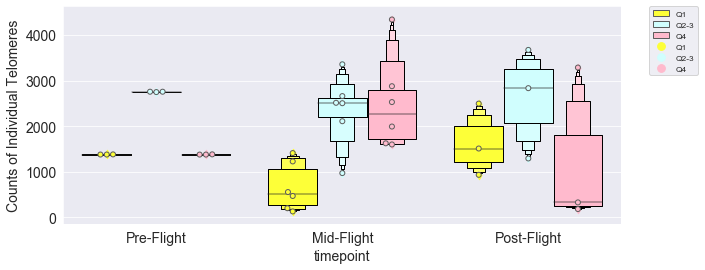

In [30]:
fig = plt.figure(figsize=(10,4))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status', y='Q freq counts', hue='relative Q', 
                   order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], 
                   data=mid_only_quartiles_df, palette=palette,
                   linewidth=2, saturation=5, color="black")

ax = sns.swarmplot(x='flight status', y='Q freq counts', hue='relative Q', 
                   order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], 
                   data=mid_only_quartiles_df, palette=palette,
                   linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_xlabel('timepoint', fontsize=14)
ax.set_ylabel('Counts of Individual Telomeres', fontsize=14)
ax.tick_params(labelsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='small')

In [41]:
mid_only_quartiles_df['flight status mid split'] = (mid_only_quartiles_df['timepoint']
                                                        .apply(lambda row: telo_ma.mid_split(row)))

Text(0, 0.5, 'Individual Telos Freqs Within first time point Quartiles')

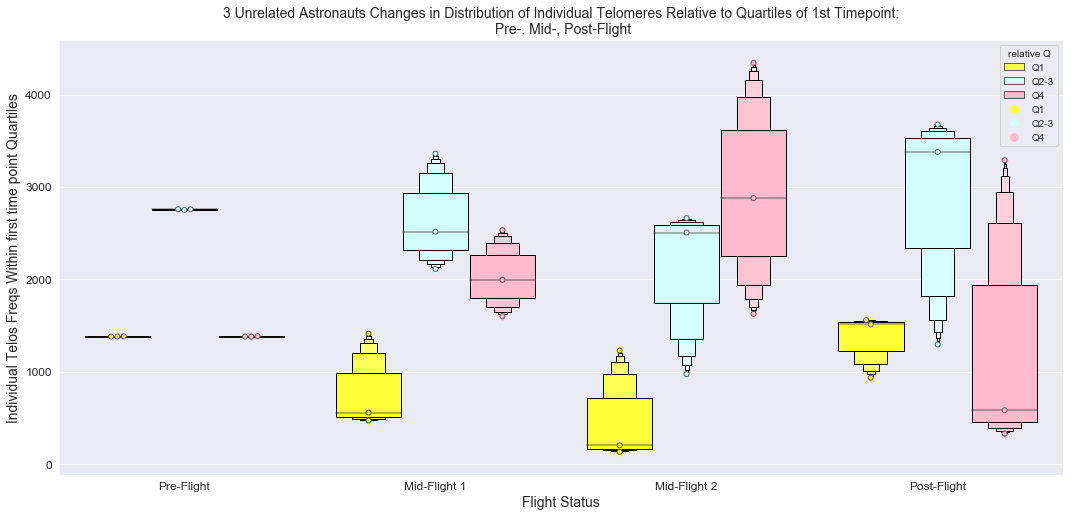

In [42]:
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status mid split', y='Q freq counts', hue='relative Q', data=mid_only_quartiles_df, palette=palette,
             linewidth=2, saturation=5, color="black")
ax = sns.swarmplot(x='flight status mid split', y='Q freq counts', hue='relative Q', data=mid_only_quartiles_df, palette=palette,
             linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_title('3 Unrelated Astronauts Changes in Distribution of Individual Telomeres Relative to Quartiles of 1st Timepoint:\n Pre-. Mid-, Post-Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=14)
ax.set_ylabel('Individual Telos Freqs Within first time point Quartiles', fontsize=14)

In [43]:
%reload_ext autoreload

##  Telo Distributions: ALL astros (less 3 inflight)

In [ ]:
# excluding midflight astros (analyzed above..); just pre/post data
exploded_telos_less_mid_astros_df = exploded_telos_astro_df[
                              (exploded_telos_astro_df['astro id'] != '5163') &
                              (exploded_telos_astro_df['astro id'] != '1536') &
                              (exploded_telos_astro_df['astro id'] != '2171')].copy()

astro_ids2 = list(exploded_telos_less_mid_astros_df['astro id'].unique())

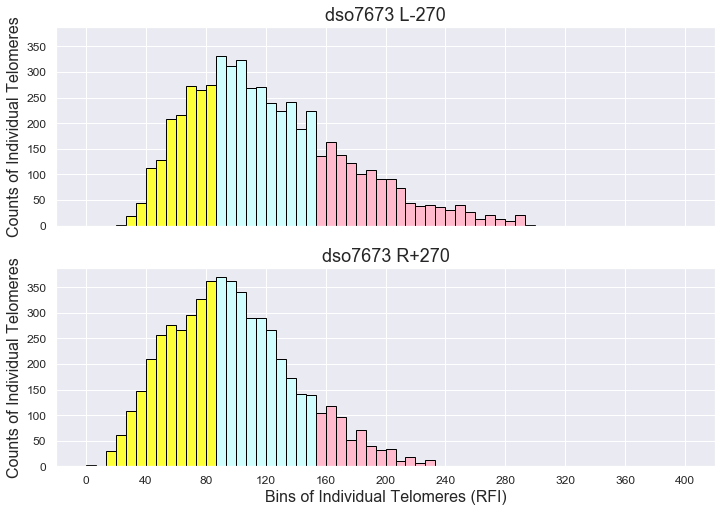

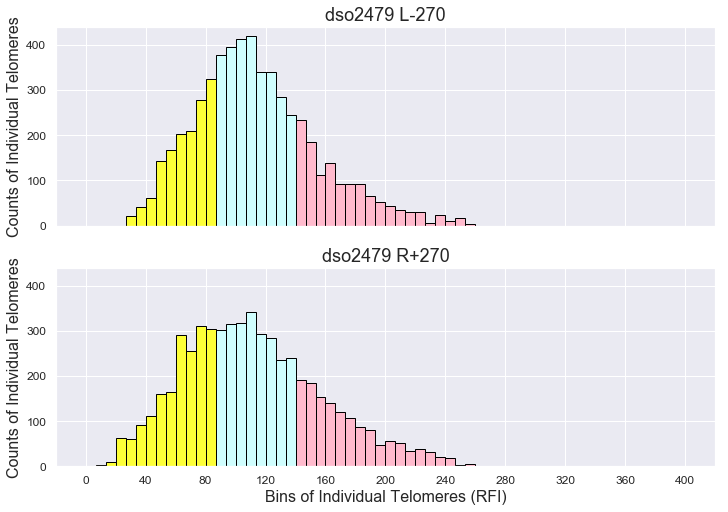

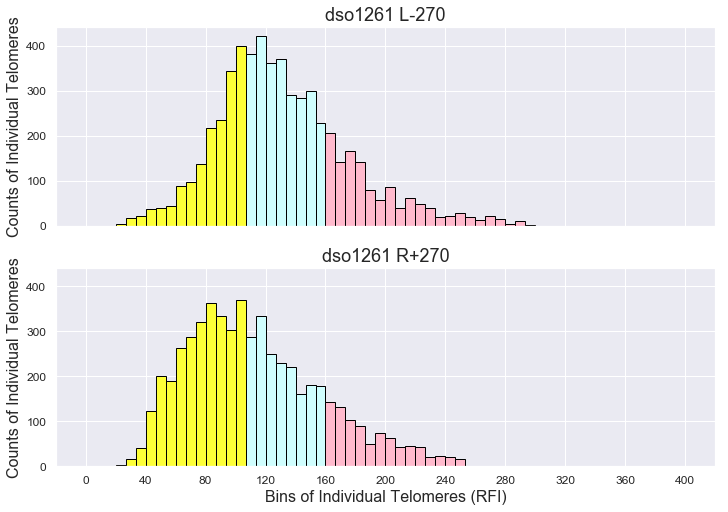

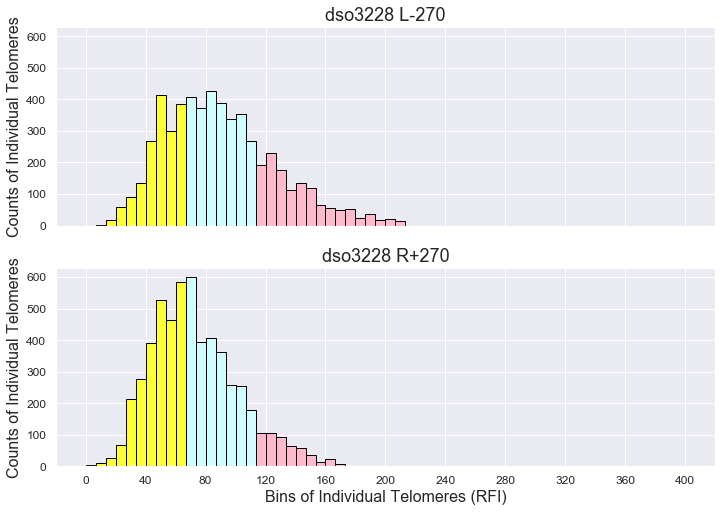

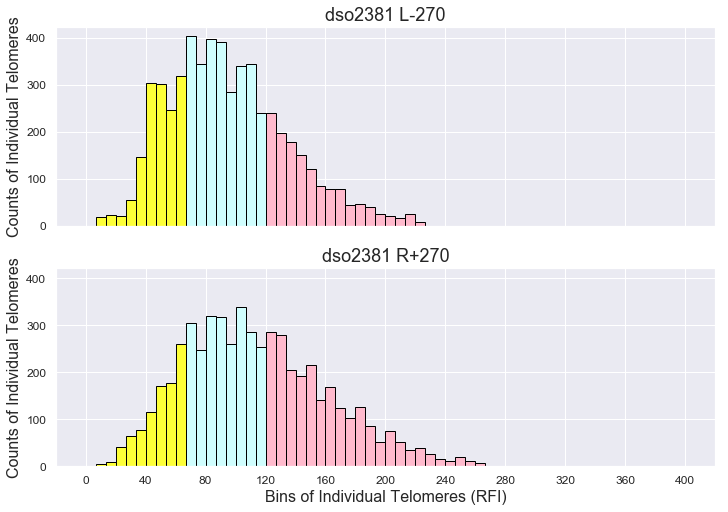

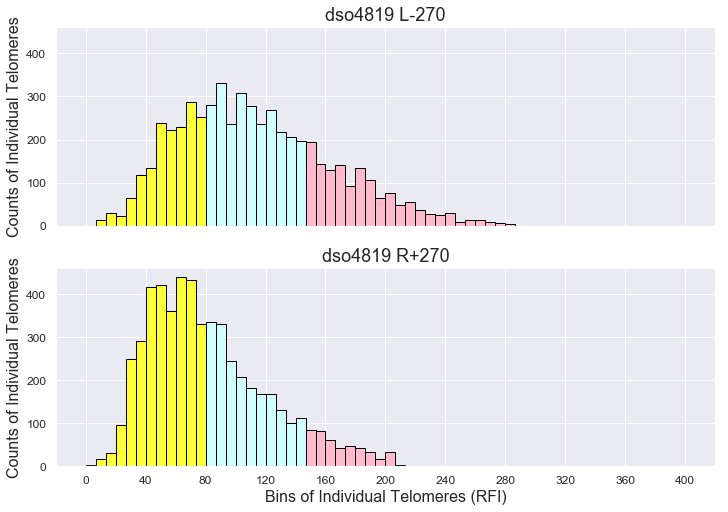

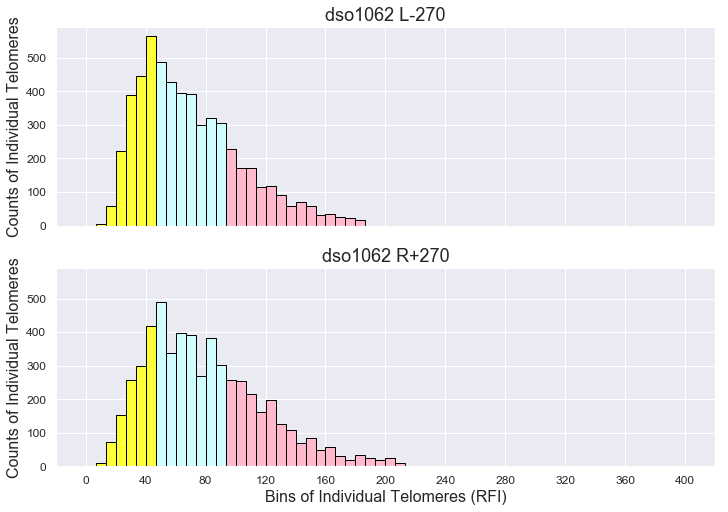

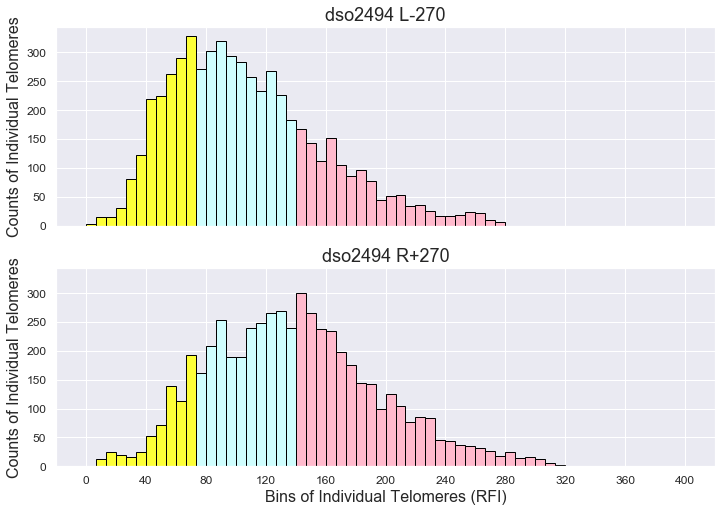

In [102]:
telo_ma.make_histograms_colored_by_quartile_for_astronauts(exploded_telos_less_mid_astros_df, astro_ids2)

## Statistics

In [104]:
grouped_by_astro_id = exploded_telos_less_mid_astros_df.groupby('astro id')

for astro_id in list(exploded_telos_less_mid_astros_df['astro id'].unique()):
    grouped_by_one_astro_id = grouped_by_astro_id.get_group(astro_id)
    
    astro_pre = grouped_by_one_astro_id[grouped_by_one_astro_id['timepoint'] == 'L-270']['telo data exploded']
    astro_post = grouped_by_one_astro_id[grouped_by_one_astro_id['timepoint'] == 'R+270']['telo data exploded']
    
    telo_ma.statistics_between_timepoints_prepost_only(astro_pre, astro_post, f'astro ID {astro_id}: L-270', f'R+270')
    

astro ID 7673: L-270  compared vs  R+270 MannwhitneyuResult(statistic=11325745.0, pvalue=7.0741794150308655e-121) 

astro ID 2479: L-270  compared vs  R+270 MannwhitneyuResult(statistic=14610900.0, pvalue=9.628209380341752e-05) 

astro ID 1261: L-270  compared vs  R+270 MannwhitneyuResult(statistic=11307332.0, pvalue=5.368198318680182e-122) 

astro ID 3228: L-270  compared vs  R+270 MannwhitneyuResult(statistic=11222148.0, pvalue=2.953091147655258e-127) 

astro ID 2381: L-270  compared vs  R+270 MannwhitneyuResult(statistic=11796302.0, pvalue=4.831918865194621e-94) 

astro ID 4819: L-270  compared vs  R+270 MannwhitneyuResult(statistic=9547527.0, pvalue=3.1147747132300456e-253) 

astro ID 1062: L-270  compared vs  R+270 MannwhitneyuResult(statistic=13058296.5, pvalue=5.97065047549006e-39) 

astro ID 2494: L-270  compared vs  R+270 MannwhitneyuResult(statistic=10165225.5, pvalue=1.0413831692098092e-201) 



## Feature engineering short/long telos: ALL astros (less 3 inflight)

In [31]:
melted_quartiles_astro_df = pd.read_csv('../data/compiled and processed data/melted_quartiles_astro_df.csv')
melted_quartiles_astro_df['astro id'] = melted_quartiles_astro_df['astro id'].astype('str')

In [22]:
d_m = melted_quartiles_astro_df[~melted_quartiles_astro_df['astro id'].isin(['2171', '5163', '1536'])]
# d_m = d_m[d_m['timepoint'].isin(['L-270', 'R+270'])].copy()
# test = pd.concat([d_m, mid_only_quartiles_df], axis=0)

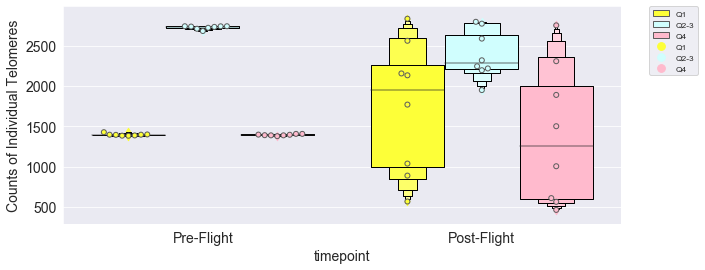

In [34]:
data = d_m

fig = plt.figure(figsize=(10,4))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status', y='Q freq counts', hue='relative Q', 
#                    order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], 
                   data=data, palette=palette,
                   linewidth=2, saturation=5, color="black")
ax = sns.swarmplot(x='flight status', y='Q freq counts', hue='relative Q', 
#                    order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                   data=data, palette=palette,
                   linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_xlabel('timepoint', fontsize=14)
ax.set_ylabel('Counts of Individual Telomeres', fontsize=14)
ax.tick_params(labelsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='small')

## Making all controls individual telomere length histogram

In [22]:
all_controls_df = pd.read_csv('../data/compiled data/All_astro_controls_telomere_length_dataframe.csv')
all_controls_df['telo data'] = all_controls_df['telo data'].apply(lambda row: np.array(literal_eval(row)))

all_controls_df.drop('flight status', axis=1, inplace=True)
print(all_controls_df.shape)

(67, 5)


In [23]:
explode_ctrl_telos_raw = all_controls_df['telo data'].apply(pd.Series)
exploded_telos_control_df = (explode_ctrl_telos_raw

    .merge(all_controls_df, right_index = True, left_index = True)                  
    .drop('telo data', axis=1)
    .melt(id_vars = ['control id', 'timepoint', 'flight status controls', 'telo means'], value_name = "telo data exploded") 
    .drop("variable", axis = 1)
    .dropna())

exploded_telos_control_df.shape

(369840, 5)

In [24]:
exploded_telos_control_df = exploded_telos_control_df[(exploded_telos_control_df['timepoint'] != 'R+7') &
                          (exploded_telos_control_df['timepoint'] != 'R+5')]

exploded_telos_control_df['flight status controls'].value_counts()

Pre-Flight     160080
Post-Flight    143520
Mid-Flight      16560
Name: flight status controls, dtype: int64

In [25]:
quartile_reference = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Pre-Flight']['telo data exploded']
pre_f = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Pre-Flight']['telo data exploded']
post_f = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Post-Flight']['telo data exploded']

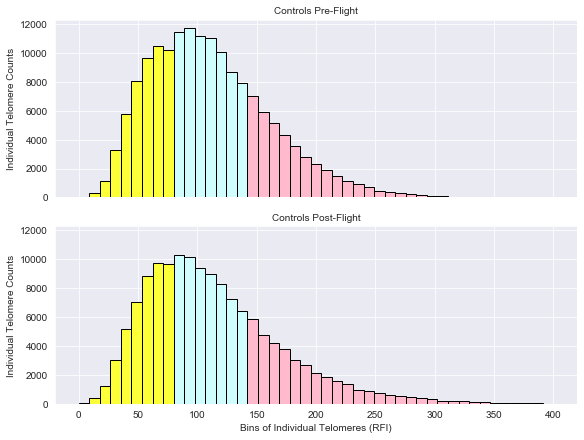

In [55]:
n_bins = 45

telo_ma.graph_two_histograms(quartile_reference, n_bins, pre_f, post_f,
                             'Controls Pre-Flight', 'Controls Post-Flight', controls=True)

plt.savefig(f'../individual telomere length histogram distributions/png/ALL CONTROLS histogram of individual telomere length distributions.png', dpi=600)
plt.savefig(f'../individual telomere length histogram distributions/svg/ALL CONTROLS histogram of individual telomere length distributions.svg', format='svg', dpi=1500)

# Urine/Blood Biochemistry Data (n=11)
___

## Reading urine analyte data (n=11) & merging with telo data

In [9]:
melt_urine_biochem_data = pd.read_csv('../data/compiled and processed data/melt_urine_biochem_data.csv')

In [10]:
# grouping astronaut data by flight status and taking mean
trim_astro_df = astro_telos_per_cell_df.drop(['astro number', 'astro id', 'telo data per cell',], axis=1)
group_astros_telos = trim_astro_df.groupby('flight status').agg('mean').reset_index()
group_astros_telos

,flight status,telo means
0,Mid-Flight,1.212613
1,Post-Flight,0.920261
2,Pre-Flight,0.938117


In [11]:
# merging analyes (not grouped as mean per flight status), astro telos grouped as mean per flight status
merge_urine_telos = melt_urine_biochem_data.merge(group_astros_telos, on='flight status')

In [12]:
merge_urine_telos.rename(columns={'telo means':'Mean Telomere Length'}, inplace=True)
merge_urine_telos.head(4)

,biochemistry analyte,sample type,timepoint,measurement,flight status,measured analyte,Mean Telomere Length
0,"8-OHdG, Urine ug/gCr",urine,Pre,2.6 ± 1,Pre-Flight,2.60,0.938117
1,"Copper, Urine umol/day",urine,Pre,0.28 ± 0.17,Pre-Flight,0.28,0.938117
2,PGF2-alpha ng/mg Cr,urine,Pre,1.84 ± 1.2,Pre-Flight,1.84,0.938117
3,"Selenium, Urine umol/day",urine,Pre,1.02 ± 0.39,Pre-Flight,1.02,0.938117


## Correlations between Urine Analytes & Mean Telomere Length (n=11)

In [13]:
# analytes retaining blood draw day correlated w/ mean telo length (pre, mid, post); provides more timepoints for corr

grouped_analytes = merge_urine_telos.groupby('biochemistry analyte')
for group in list(merge_urine_telos['biochemistry analyte'].unique()):
    print( f"{group}: {grouped_analytes.get_group(group).corr()['Mean Telomere Length'][0]:.4f}" ) 

8-OHdG, Urine ug/gCr: 0.7800
Copper, Urine umol/day: -0.5629
PGF2-alpha ng/mg Cr: 0.8967
Selenium, Urine umol/day: 0.8535


## Graphing urine biochemistry analyte correlations with telomere length (n=11)

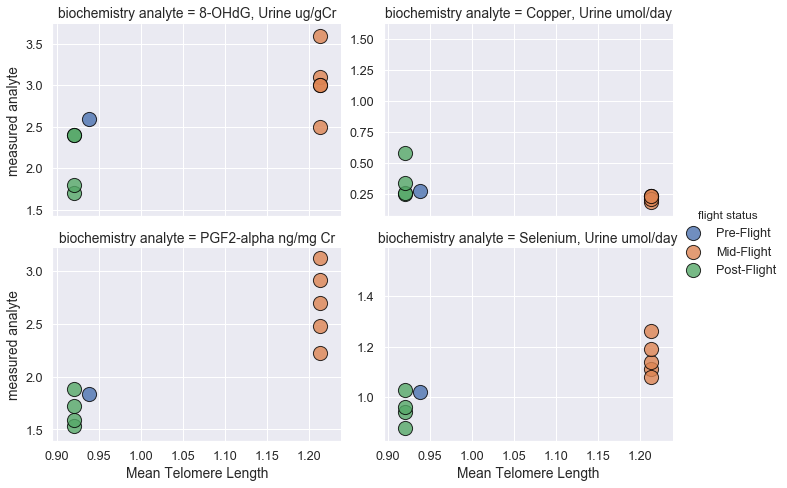

In [53]:
ax = sns.set(font_scale=1.15)
ax = sns.lmplot(x='Mean Telomere Length', y='measured analyte', hue='flight status', 
                col='biochemistry analyte', col_wrap=2,
                data=merge_urine_telos,
                sharex=True,
                sharey=False,
                fit_reg=False, scatter_kws={'s':200, 'edgecolor':'black', 'linewidth':1},
                height=3.5, aspect=1.4,
                hue_order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'],
          )

# ax.savefig('graph data/biochemistry correlations/scatterplot correlations urine analytes mean telomere length.png', dpi=400)

## Reading in blood analyte data (n=11) & merging with telo data

In [143]:
melt_blood_biochem_data = pd.read_csv('../data/compiled and processed data/melt_blood_biochem_data.csv')

In [144]:
astro_telos_per_cell_df = pd.read_csv('../data/compiled and processed data/exploded_cells_astros_df.csv')
astro_telofish_grouped = astro_telos_per_cell_df.groupby(by=['astro id', 'timepoint', 'flight status']).agg('mean').reset_index()

In [154]:
# astronauts telomere qpcr df
astro_telos_qpcr_df = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[0, 1, 2])
astro_telos_qpcr_df.dropna(axis=0, inplace=True)
astro_telos_qpcr_df['astro id'] = astro_telos_qpcr_df['astro id'].astype('int64')    
astro_telos_qpcr_df['flight status'] = astro_telos_qpcr_df['timepoint'].apply(lambda row: telo_ma.flight_status(row))

astro_telos_qpcr_grouped = (astro_telos_qpcr_df
                            .groupby(by=['astro id', 'timepoint', 'flight status'])
                            .agg('mean').reset_index())

astro_telos_qpcr_grouped['timepoint'] = astro_telos_qpcr_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

In [174]:
astro_telos_qpcr_grouped = astro_telos_qpcr_grouped.merge(astro_telofish_grouped[['astro id', 'astro number']], 
                                                          on=['astro id']).copy()

## Merge blood analyte and mean telomere length data (n=11)

(222, 6)


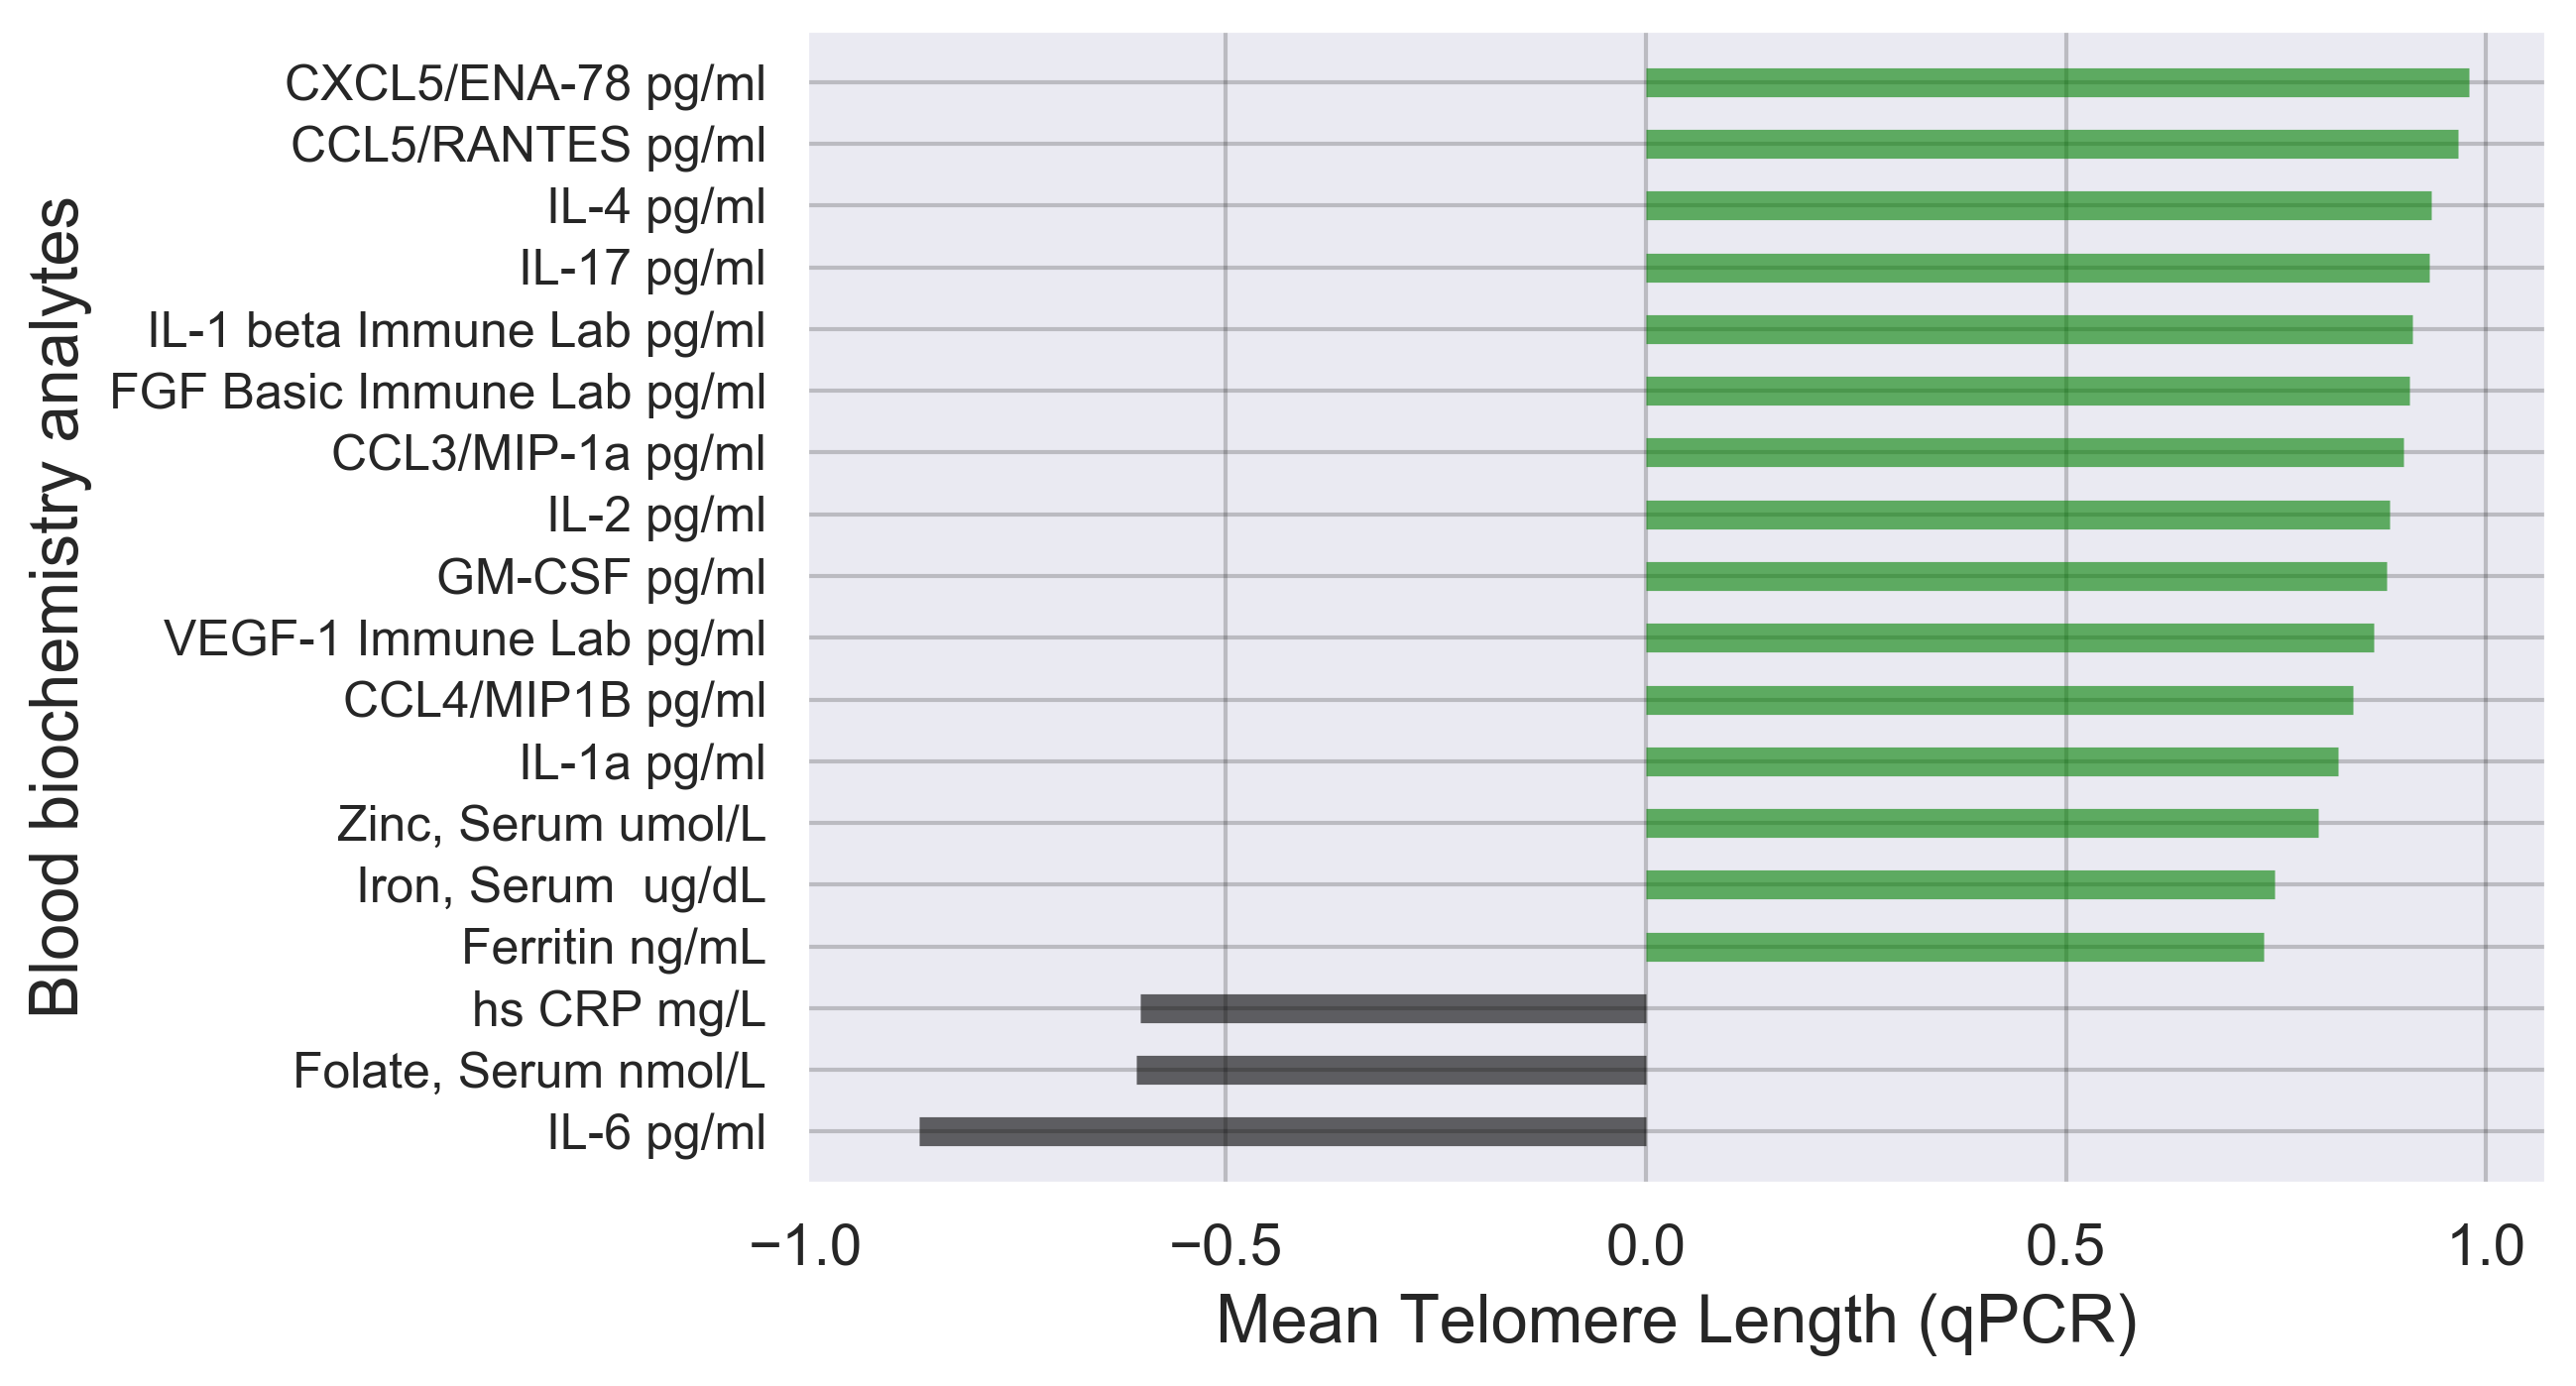

In [184]:
target='Mean Telomere Length (qPCR)'
df=astro_telos_qpcr_grouped

# merge analyte & telomere data
blood_n11_drop_rows_all_status = telo_ma.correlate_astro_analytes_telomeres_pipeline(
                                                                    analyte_df=melt_blood_biochem_data, 
                                                                    telomere_df=df,
                                                                    target=target,
                                                                    astro_ids_of_interest='all astros',
                                                                    how_drop_missing='by melted row', 
                                                                    retain_what_flight_status='require at least one per status',
                                                                    telos_percent_change='no')
print(blood_n11_drop_rows_all_status.shape)

# find highly correlated analytes
corr_value_tests = telo_ma.find_high_correlates_analytes_mean_telos(blood_n11_drop_rows_all_status, 0.6, corr_loc=0,
                                                                    astro_ids=False,
                                                                    target=target)

# turn correlated analytes/mean telomere length into dataframe
blood_n11_high_corr_values = pd.DataFrame(corr_value_tests, columns=['biochemistry analyte', 'correlation value'])

# plot diverging bars correlates
telo_ma.plot_diverging_correlations(list_correlates=blood_n11_high_corr_values,target_name=target, figsize=(9,5))

## Experimental visualizations of analytes vs. mean telomere length 

In [134]:
test = blood_n11_drop_rows_all_status.groupby(['biochemistry analyte', 'timepoint']).agg('mean').reset_index()

test['timepoint'] = test['timepoint'].astype('category')
test['timepoint'].cat.reorder_categories(['Pre', 'FD15', 'FD30', 'FD60', 'FD120', 'FD180', 'R+0', 'R+180'], inplace=True)

alpha2 = test[test['biochemistry analyte'] == 'CXCL5/ENA-78 pg/ml'].copy()
# test[test['biochemistry analyte'] == 'CXCL5/ENA-78 pg/ml']

In [136]:
timepoint_order = ['Pre', 'FD15', 'FD30', 'FD60', 'FD120', 'FD180', 'R+0', 'R+180']
df = alpha2.set_index('timepoint').loc[timepoint_order]

In [138]:
# plt.figure(figsize=(7, 3.2))
# ax = sns.set(font_scale=1.5)

# ax = sns.lineplot(x='timepoint', y='measured analyte', color='g', data=alpha2, markers=True, dashes=True,)
# ax2 = plt.twinx()
# sns.lineplot(x='timepoint', y='Mean Telomere Length (qPCR)', color='purple', data=alpha2, ax=ax2, markers=True, dashes=True,)

## Graphing Blood (n=11) correlations with Telomere Length

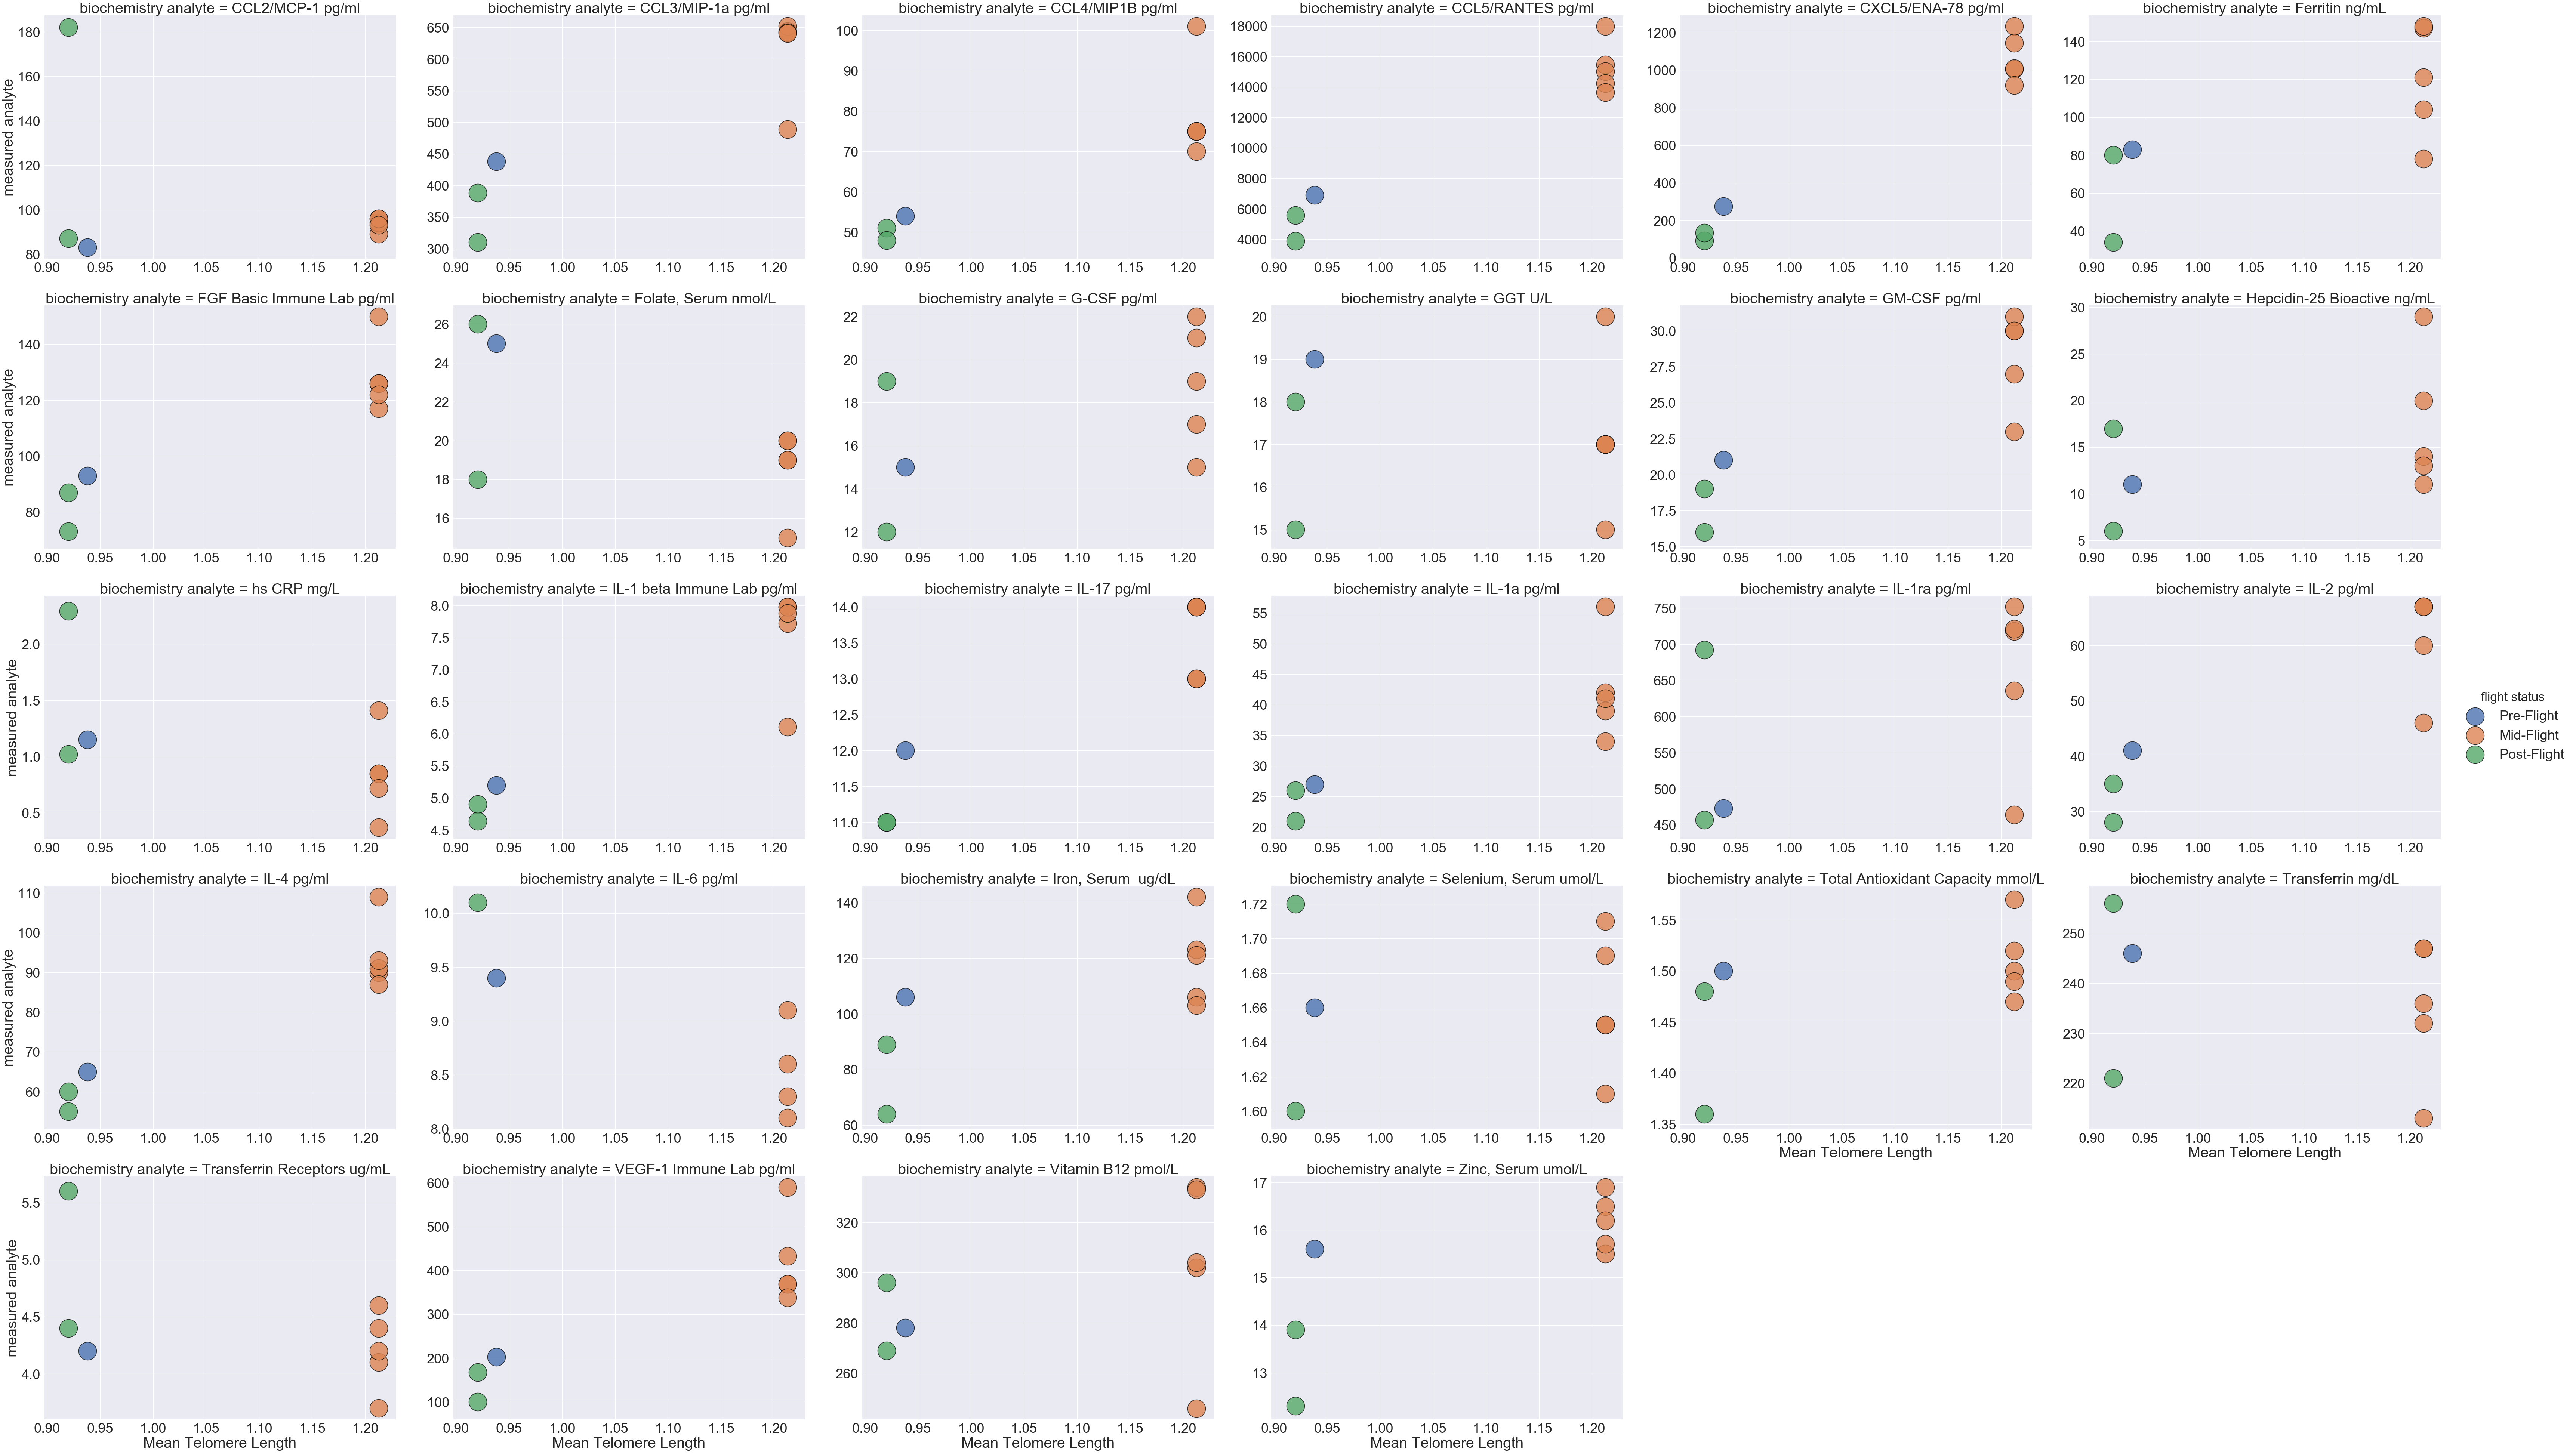

In [64]:
ax = sns.set(font_scale=3.3)
ax = sns.lmplot(x='Mean Telomere Length', y='measured analyte', hue='flight status', 
                col='biochemistry analyte', col_wrap=6,
                data=blood_n11_drop_rows_all_status,
                sharey=False,
                sharex=False,
                fit_reg=False,
                hue_order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                scatter_kws={'s':2300, 'edgecolor':'black', 'linewidth':1.5},
                height=11, aspect=1.4,
          )
# plt.tight_layout()
# plt.show()
# ax.savefig('graph data/biochemistry correlations/scatterplot correlations blood analytes mean telomere length.png')

# EDA qPCR chr aberr data

## Clustering 11 astros by inversions (flight status)

In [75]:
merged = telo_ma.pull_merge_all_data(merge_what_data=['qpcr', 'telofish'],
                                     how_groupby_telo_data=['astro id', 'timepoint'])

In [76]:
aberr_df = telo_ma.pull_aberr_df()

aberr_df['flight status'] = aberr_df['flight status'].astype('str')
invs = aberr_df[['astro id', 'flight status', 'inversions']].copy()
invs = invs[invs['flight status'] != 'Mid-Flight'].copy()

invs.columns.name = ''

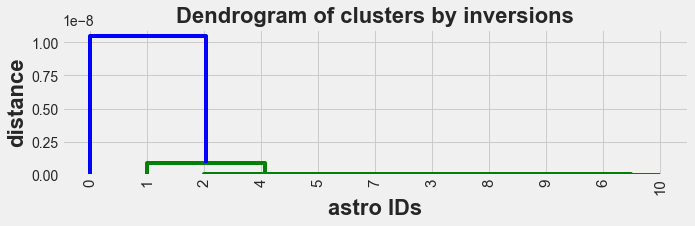

0 Cluster number 2 has 1 elements
1 Cluster number 1 has 10 elements


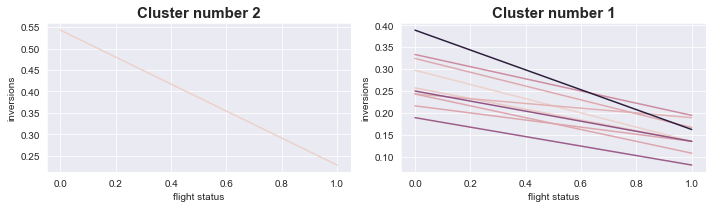

In [77]:
clustered_invs = telo_ma.cluster_data_return_df(invs, 'inversions', time='flight status', cut_off_n=2, 
                                                verbose=True, y_size=3, x_size=10)

In [78]:
import importlib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


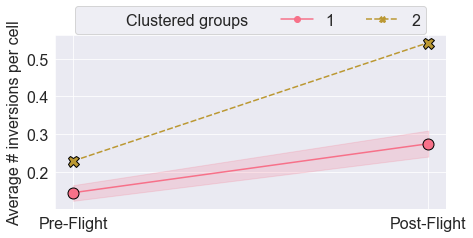

In [79]:
clustered_invs.rename({'inversions cluster groups': 'Clustered groups'}, axis=1, inplace=True)
clustered_invs['flight status'] = clustered_invs['flight status'].astype('category')
clustered_invs['flight status'].cat.reorder_categories(['Pre-Flight', 'Post-Flight'], inplace=True)

telo_ma.graph_cluster_groups(clustered_invs, time='flight status', target='inversions', 
                             hue='Clustered groups', colors='husl', figsize=(7, 3.2),
                             n_cols=4, y_label_name='Average # inversions per cell', 
                             save=True, fontsize=16, bbox_to_anchor=(0.5, 1.21))

In [80]:
pivot = invs.pivot_table(index='astro id', columns='flight status', values='inversions')
pivot = pivot[['Pre-Flight', 'Post-Flight']].copy()

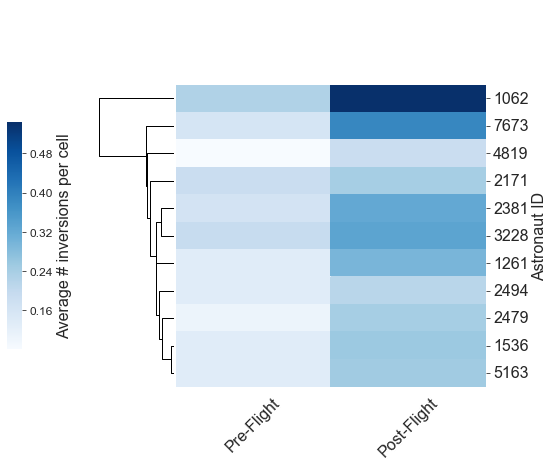

In [81]:
telo_ma.clustermap_plot(pivot, z_score=None, color_map='Blues',
                        y_label='Average # inversions per cell', 
                        metric='euclidean', save=True, fontsize=16)

# 1062 wp

## Clustering 3 astros by inversions (flight status)

In [61]:
# pulling out 3 astros
aberr_df = telo_ma.pull_aberr_df()
aberr_df['flight status'] = aberr_df['flight status'].astype('str')
invs_3 = aberr_df[['astro id', 'flight status', 'inversions']].copy()


invs_3 = invs_3[invs_3['astro id'].isin([2171, 5163, 1536])]

invs_3.columns.name = ''

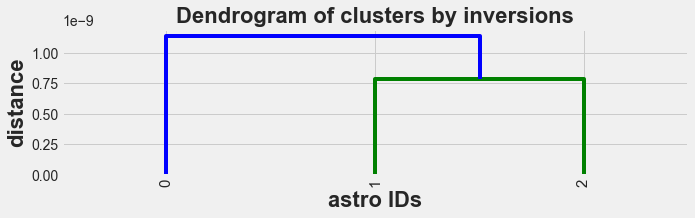

0 Cluster number 1 has 3 elements


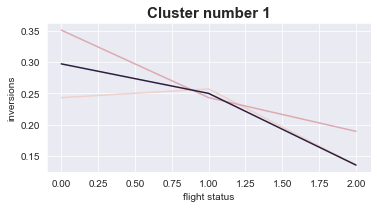

In [84]:
clustered_invs_3 = telo_ma.cluster_data_return_df(invs_3, 'inversions', time='flight status', cut_off_n=1, 
                                                  verbose=True, y_size=3, x_size=10)

In [87]:
clustered_invs_3['inversions cluster groups'] = clustered_invs_3['astro id'].apply(lambda row: 1 if row == 2171 else 2)

In [89]:
# clustered_invs_3

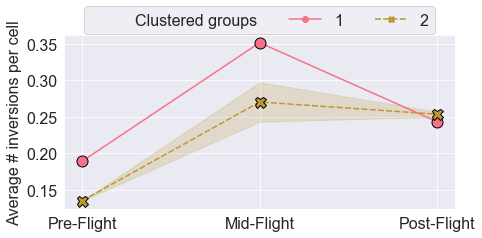

In [90]:
clustered_invs_3.rename({'inversions cluster groups': 'Clustered groups'}, axis=1, inplace=True)
clustered_invs_3['flight status'] = clustered_invs_3['flight status'].astype('category')
clustered_invs_3['flight status'].cat.reorder_categories(['Pre-Flight', 'Mid-Flight', 'Post-Flight'], inplace=True)

telo_ma.graph_cluster_groups(clustered_invs_3, time='flight status', target='inversions', 
                             hue='Clustered groups', colors='husl', figsize=(7, 3.2),
                             n_cols=4, y_label_name='Average # inversions per cell', 
                             save=True, fontsize=16, bbox_to_anchor=(0.5, 1.21),
                             path_labels='3 astros')

In [91]:
pivot_3 = invs_3.pivot_table(index='astro id', columns='flight status', values='inversions')
pivot_3 = pivot_3[['Pre-Flight', 'Mid-Flight', 'Post-Flight']].copy()

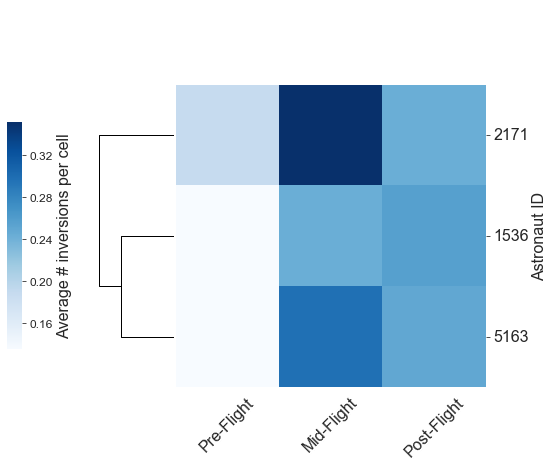

In [92]:
telo_ma.clustermap_plot(pivot_3, z_score=None, color_map='Blues',
                        y_label='Average # inversions per cell', 
                        metric='euclidean', save=True, fontsize=16,
                        path_labels='3 astros')

# 1062 wp

In [48]:
f_scaled = StandardScaler().fit_transform(x)
features_scaled = pd.DataFrame(f_scaled)

pca_features = PCA(n_components=5).fit_transform(features_scaled)
pca_ftrs_df = pd.DataFrame(pca_features)

NameError: name 'x' is not defined

In [397]:
PCA().fit(features_scaled).explained_variance_ratio_

array([0.3410951 , 0.19517142, 0.13632529, 0.0956372 , 0.07596154,
       0.06174873, 0.05690637, 0.01985895, 0.01729539])